In [2]:
import sys, os
sys.path.append(os.path.abspath('../'))

In [3]:

# saved files testing
from src.utils.flow import *
from src.utils.flow_calculations import *
from src.utils.restoration import *
from src.utils.truncated_packet import *
from src.operations.size_perturbation_logic import *
from src.operations.timing_perturbation_logic import *
from src.operations.calculate_fitness import *

modified_pcap_path = "../data/interim/testing_small_perturbed.pcapng"
pcap_file_path = '../data/raw/botnet-capture-20110816-donbot.pcap'

In [7]:
truncated_packets = create_truncated_packets_from_pcap(pcap_file_path)
truncated_packets = assign_flow_ids_to_packets(truncated_packets)
flow_id = 1

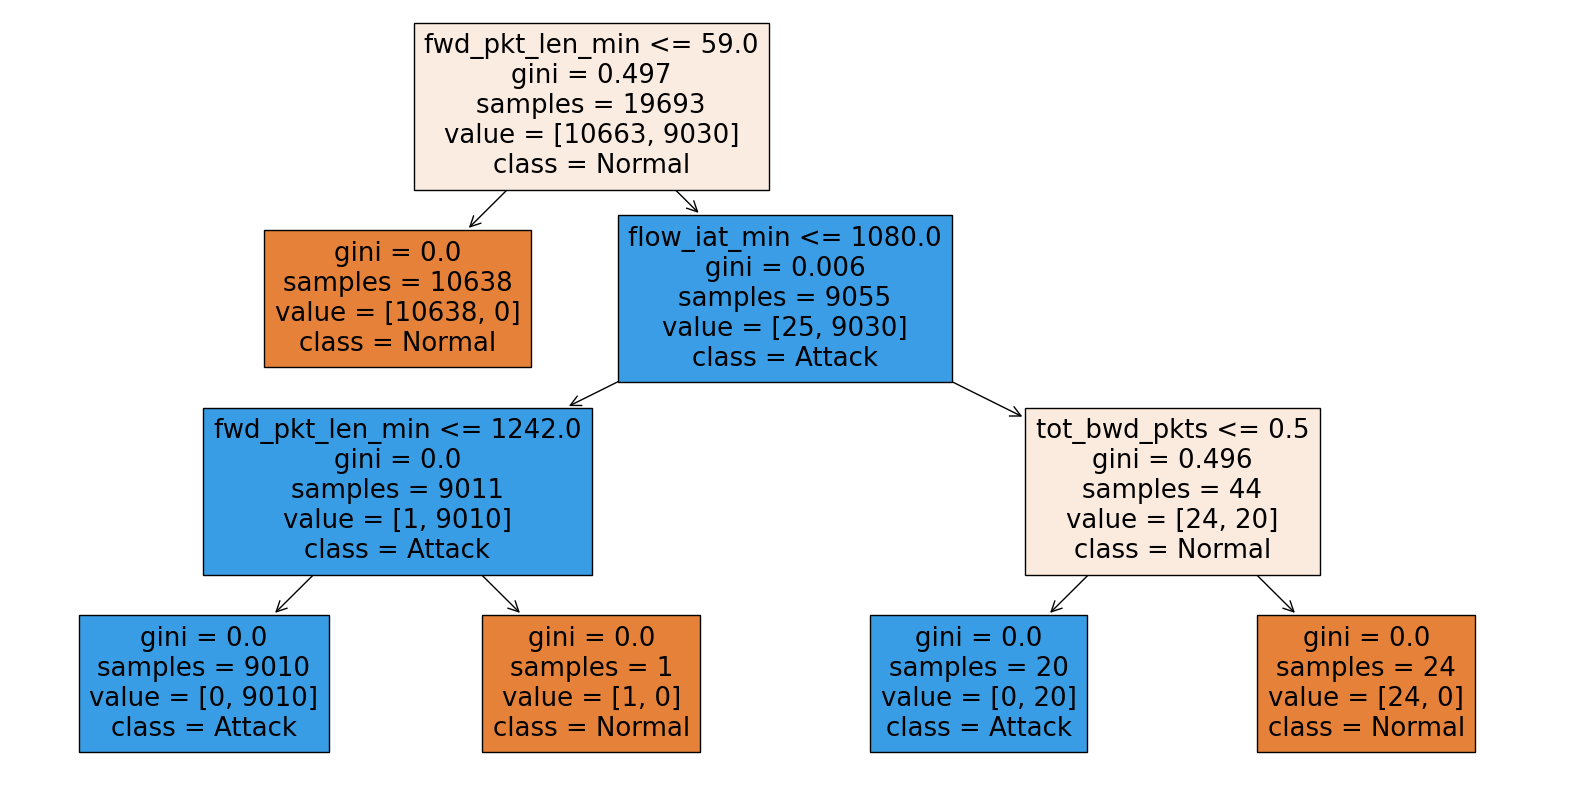

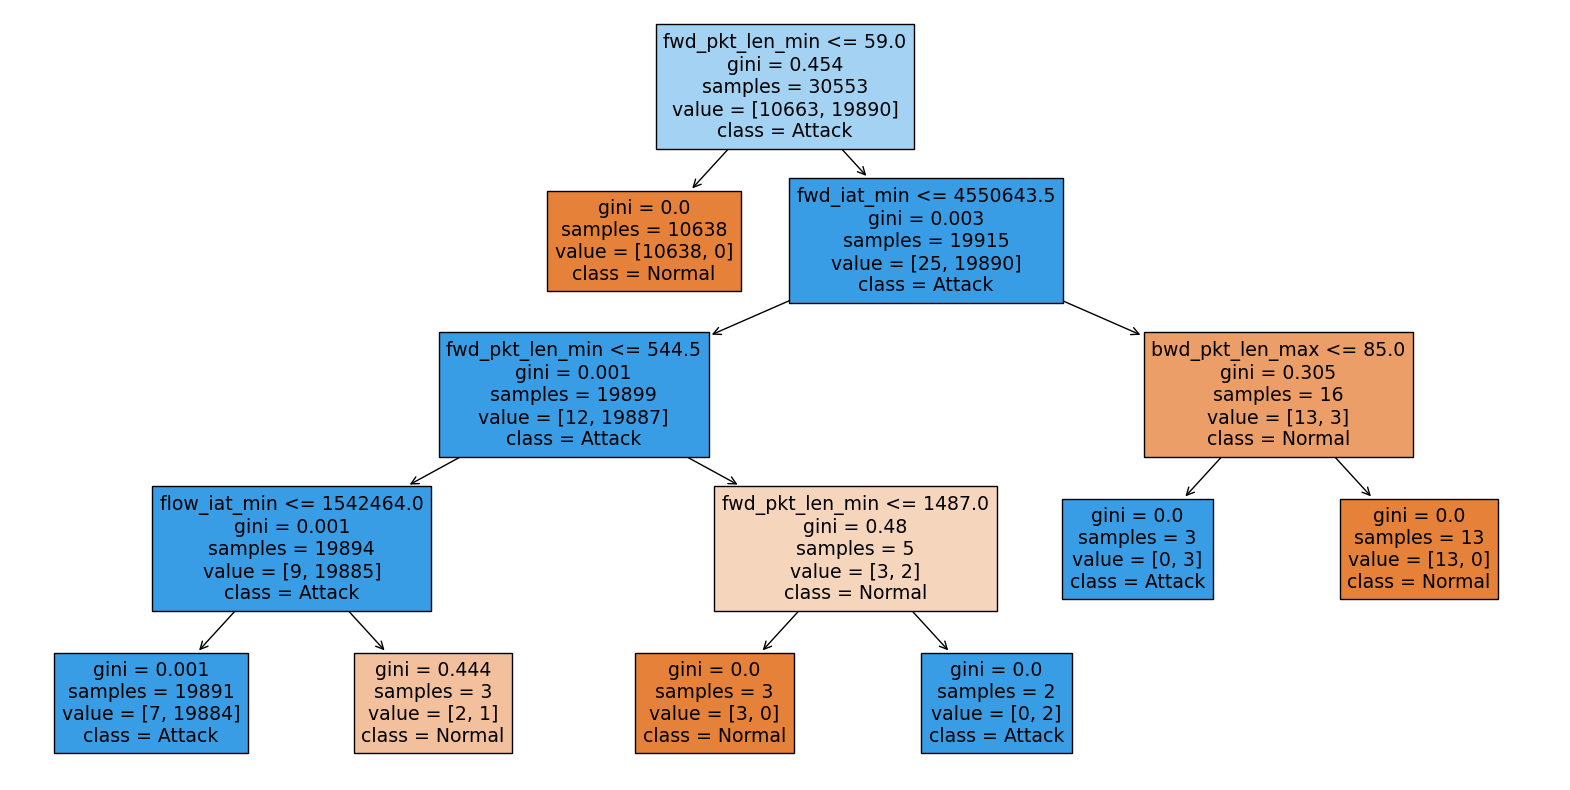

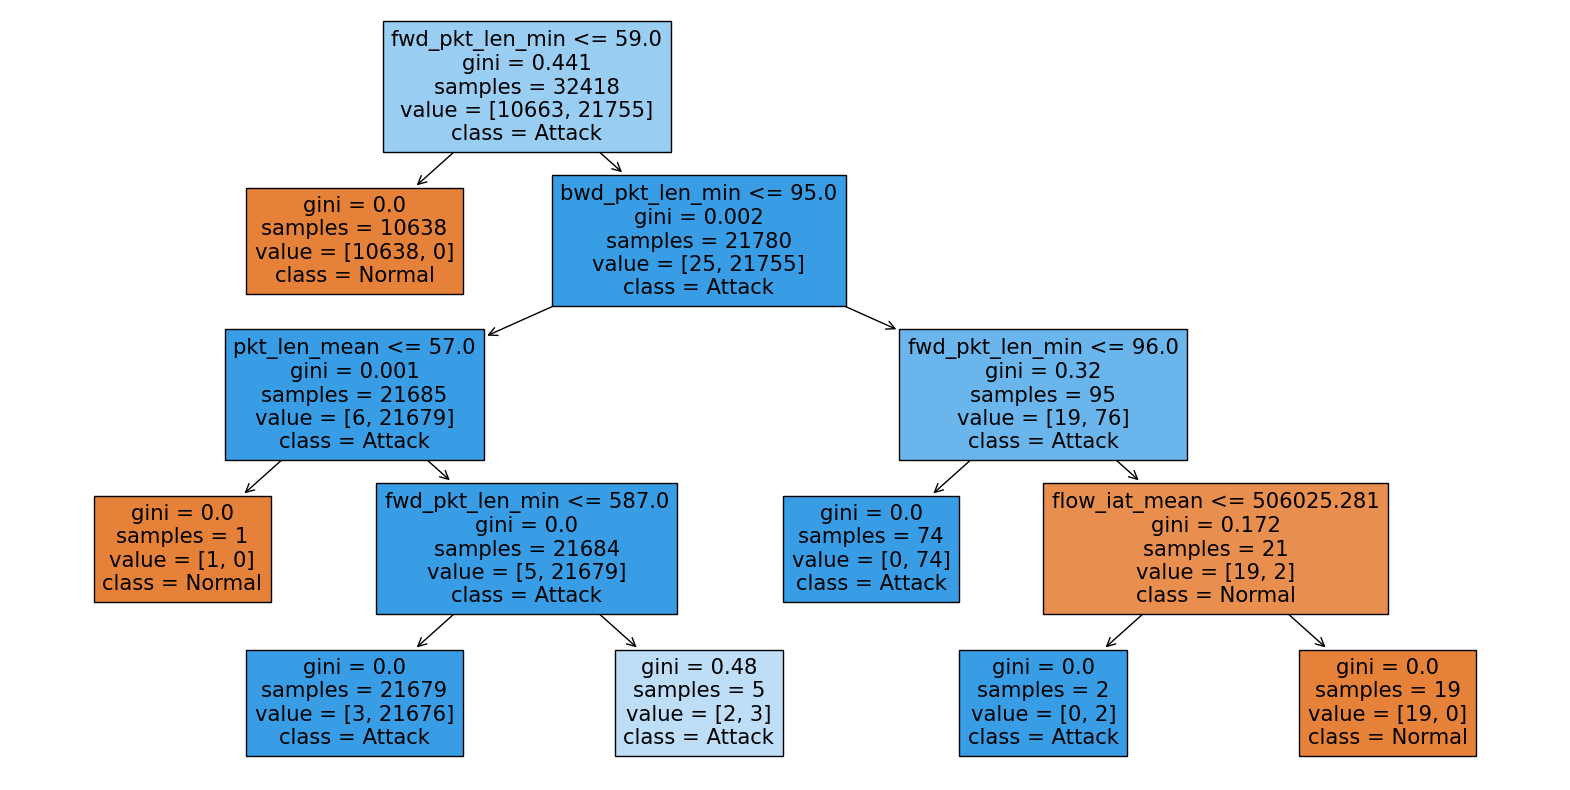

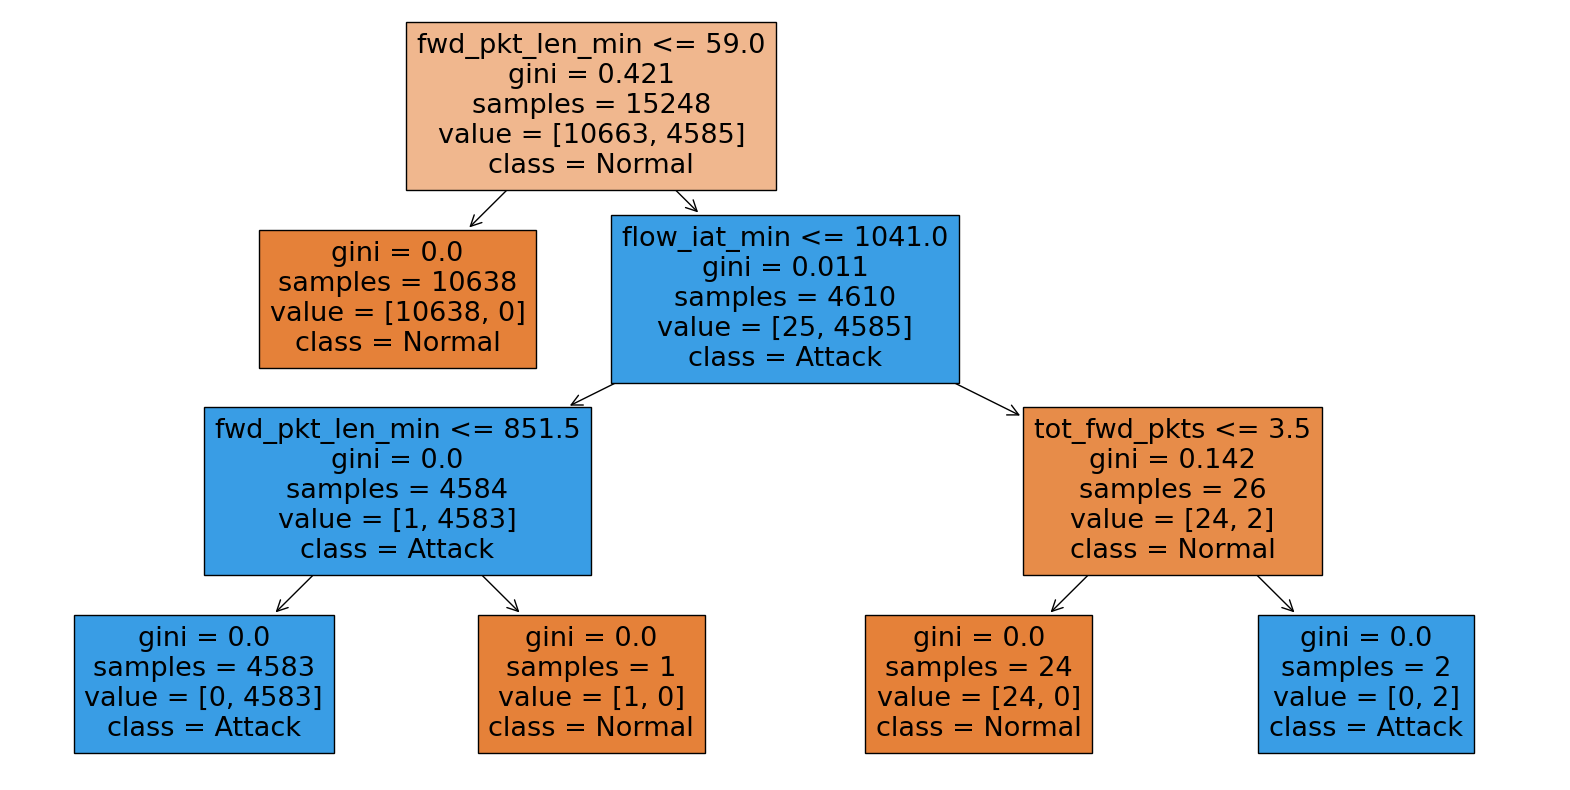

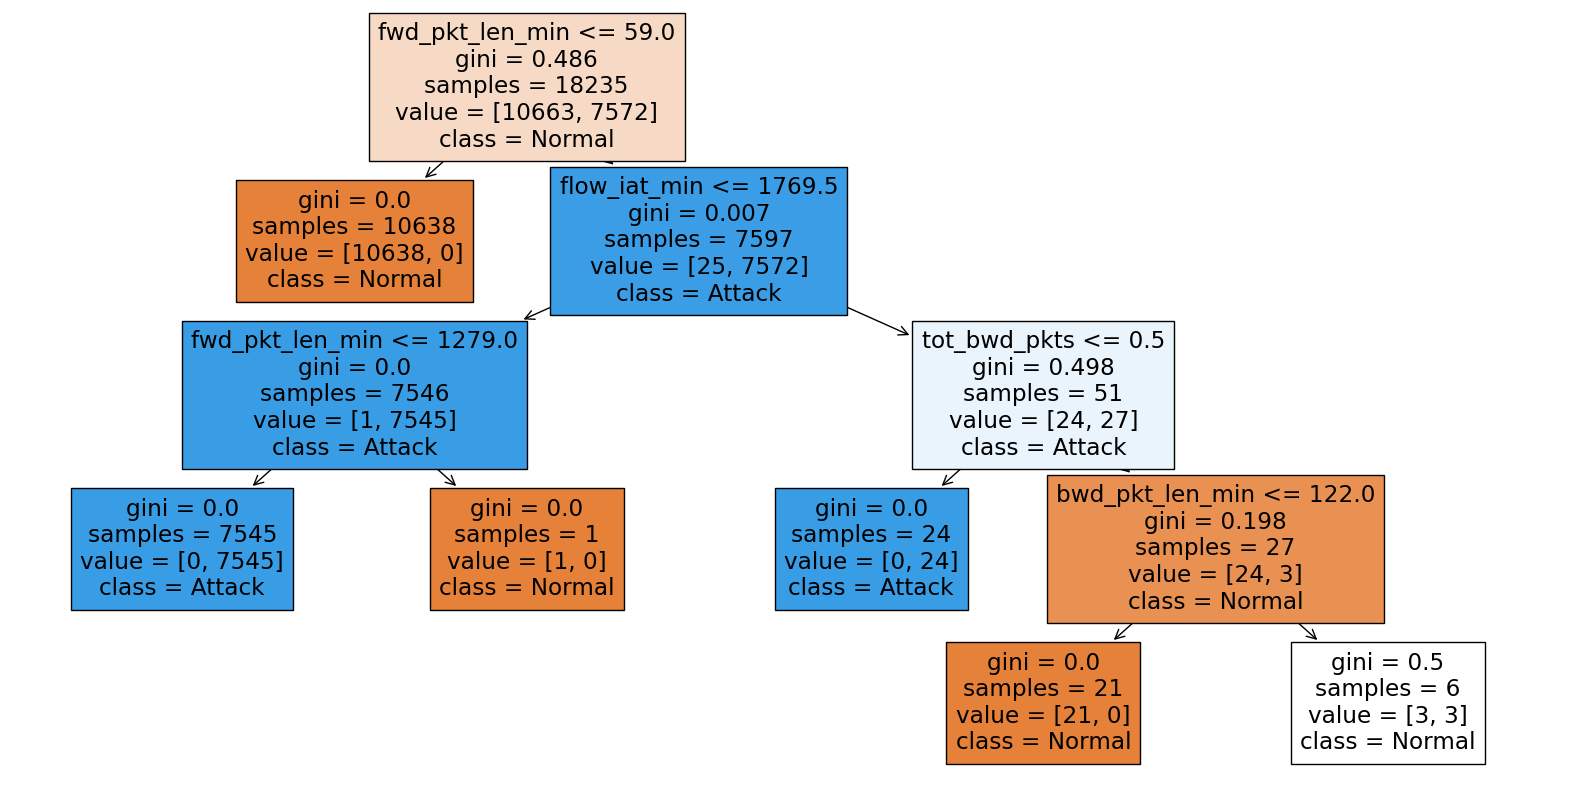

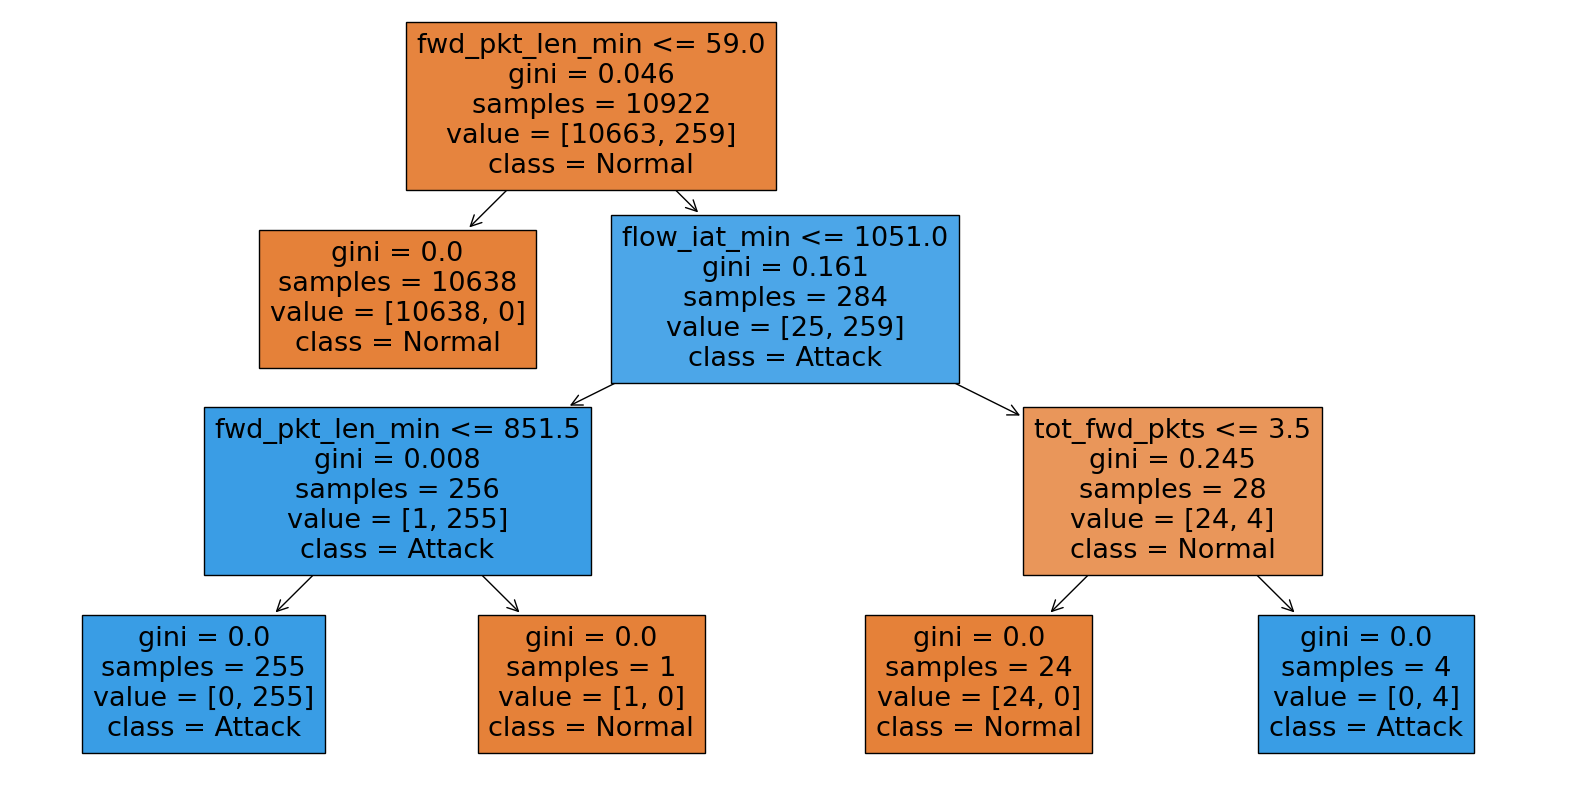

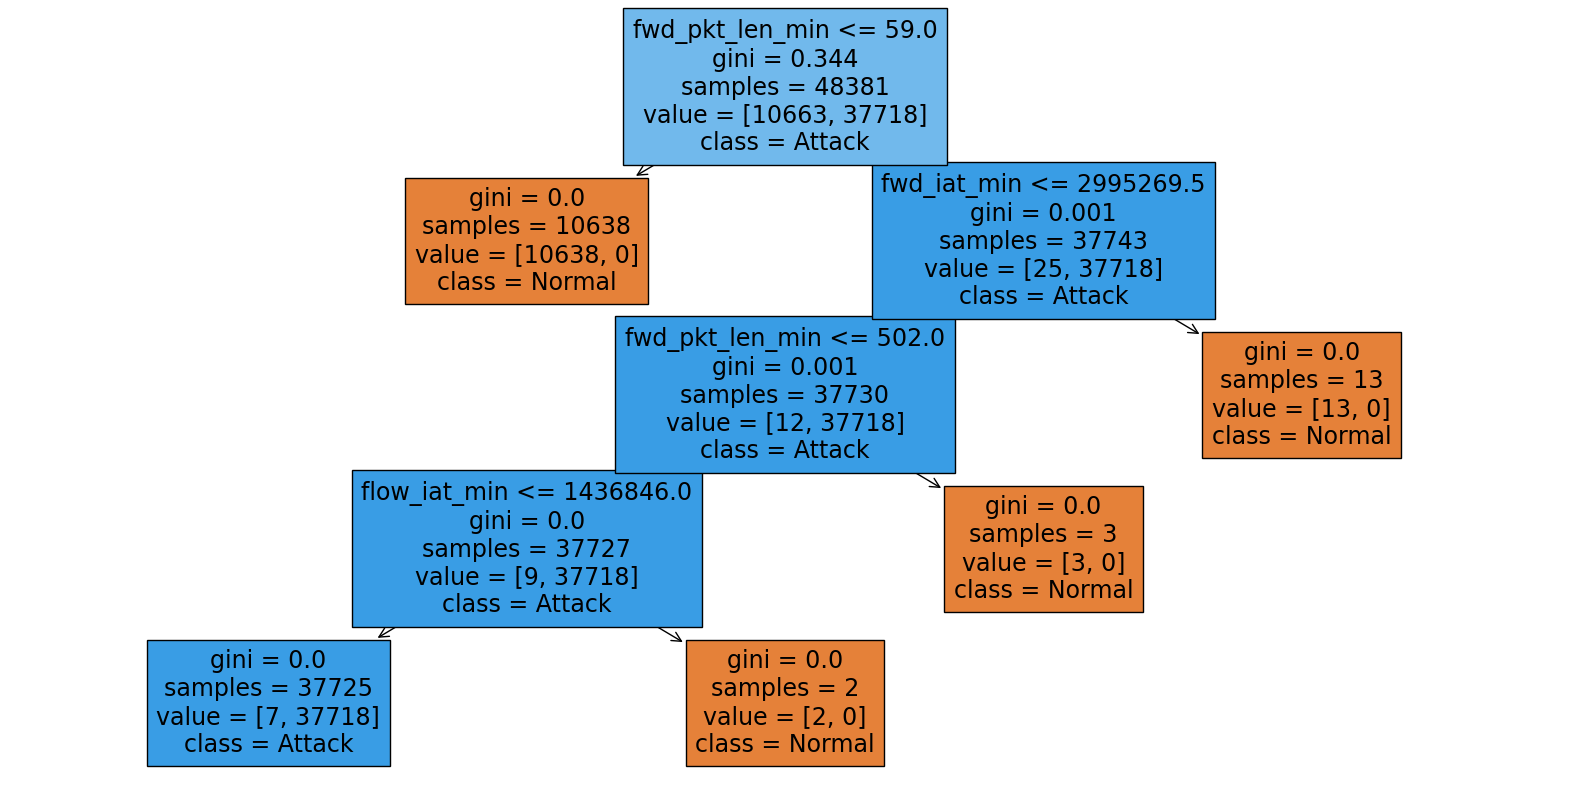

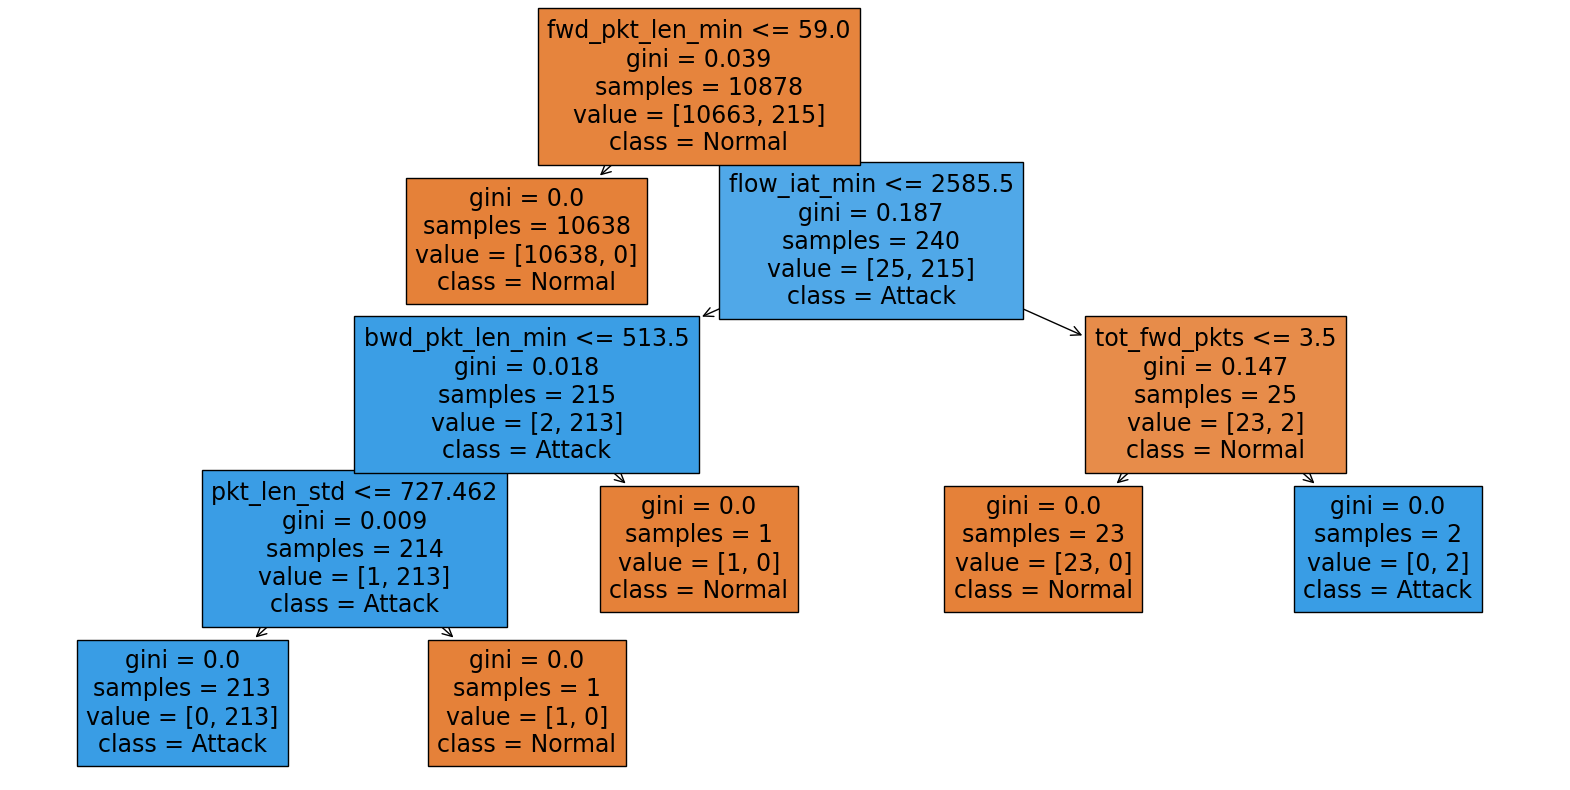

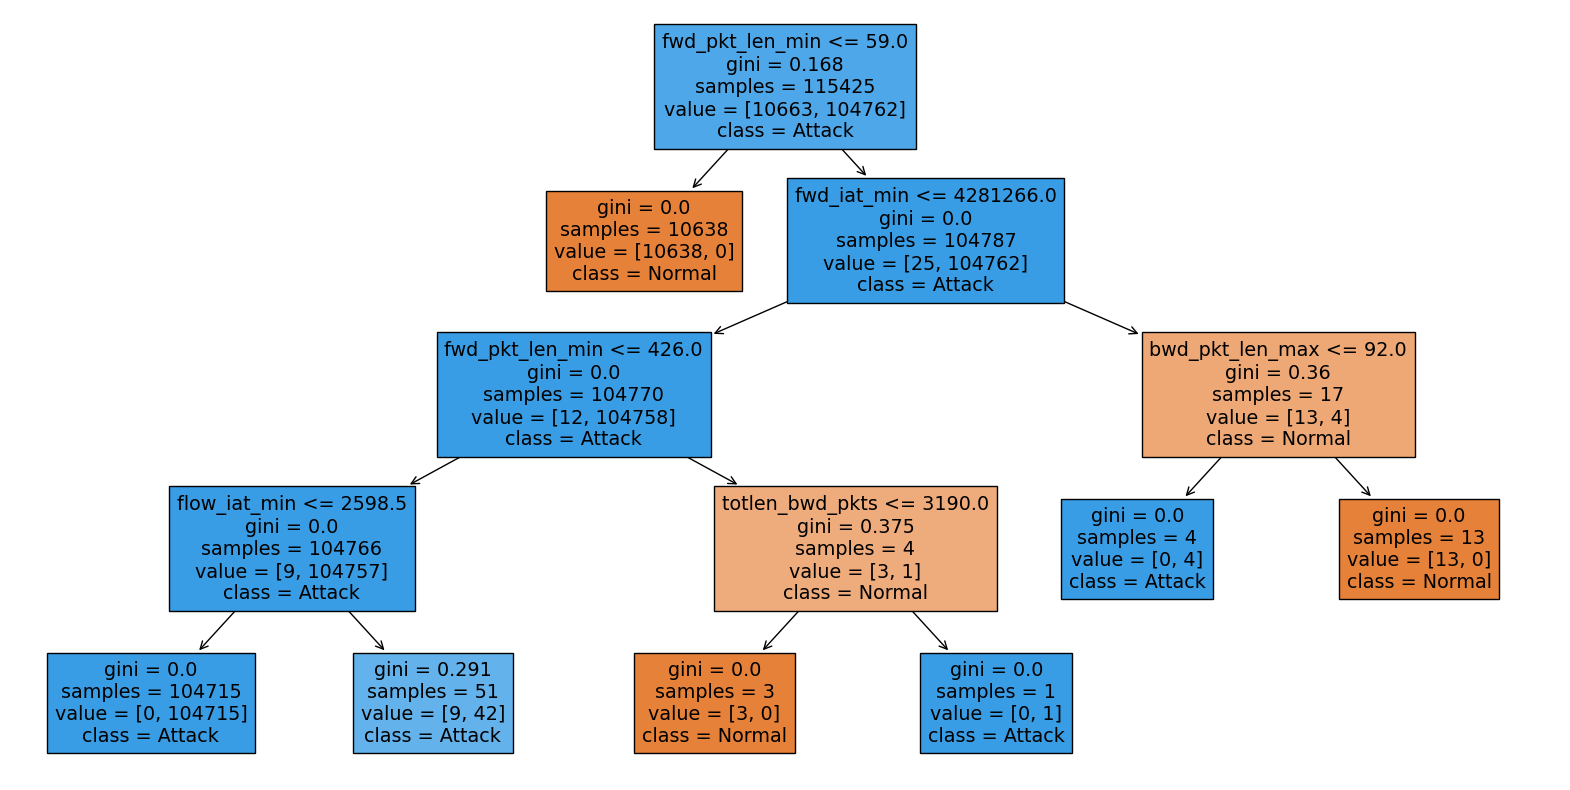

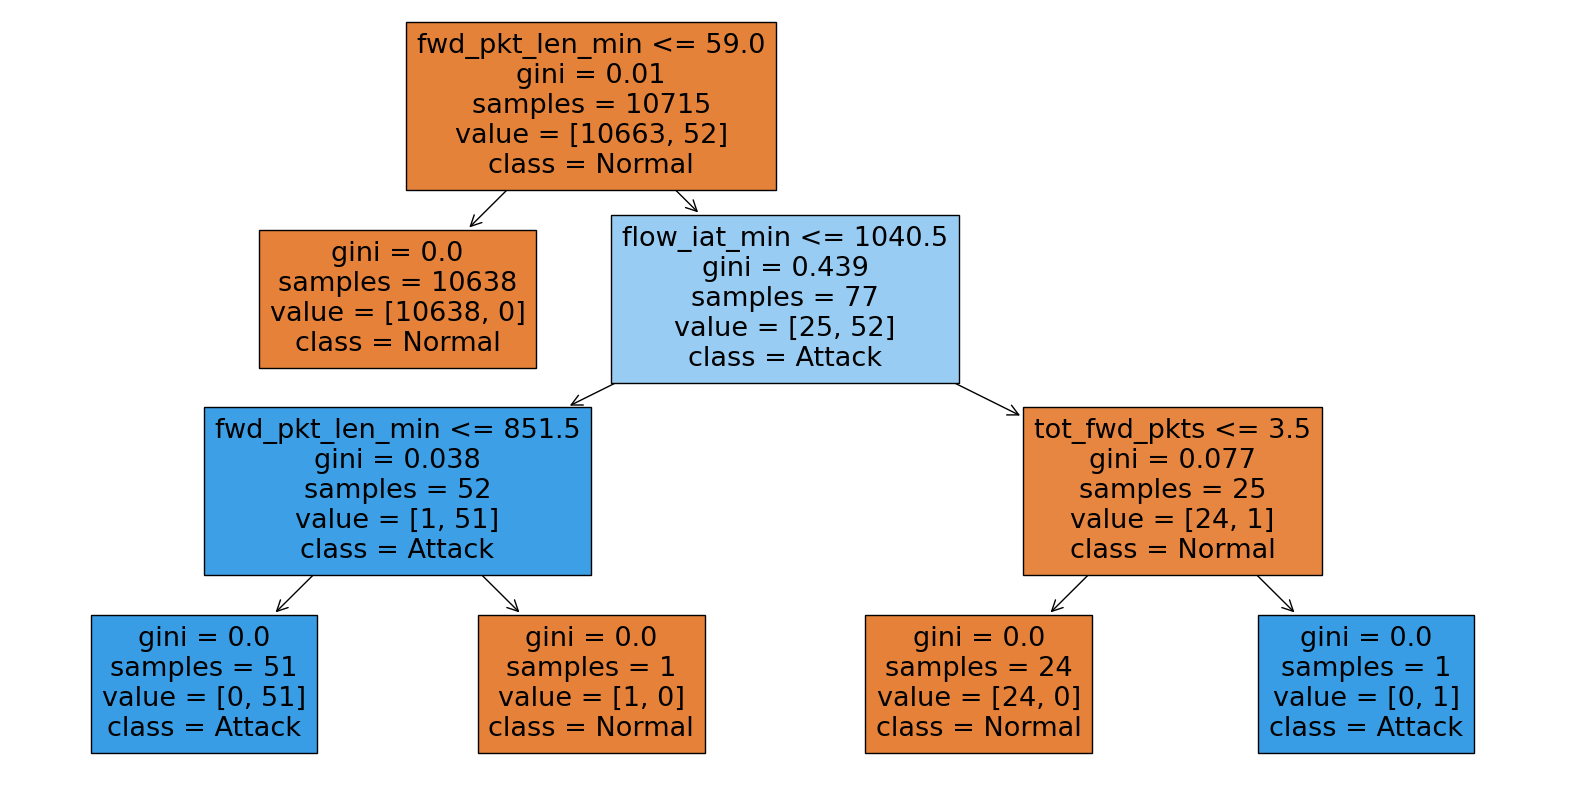

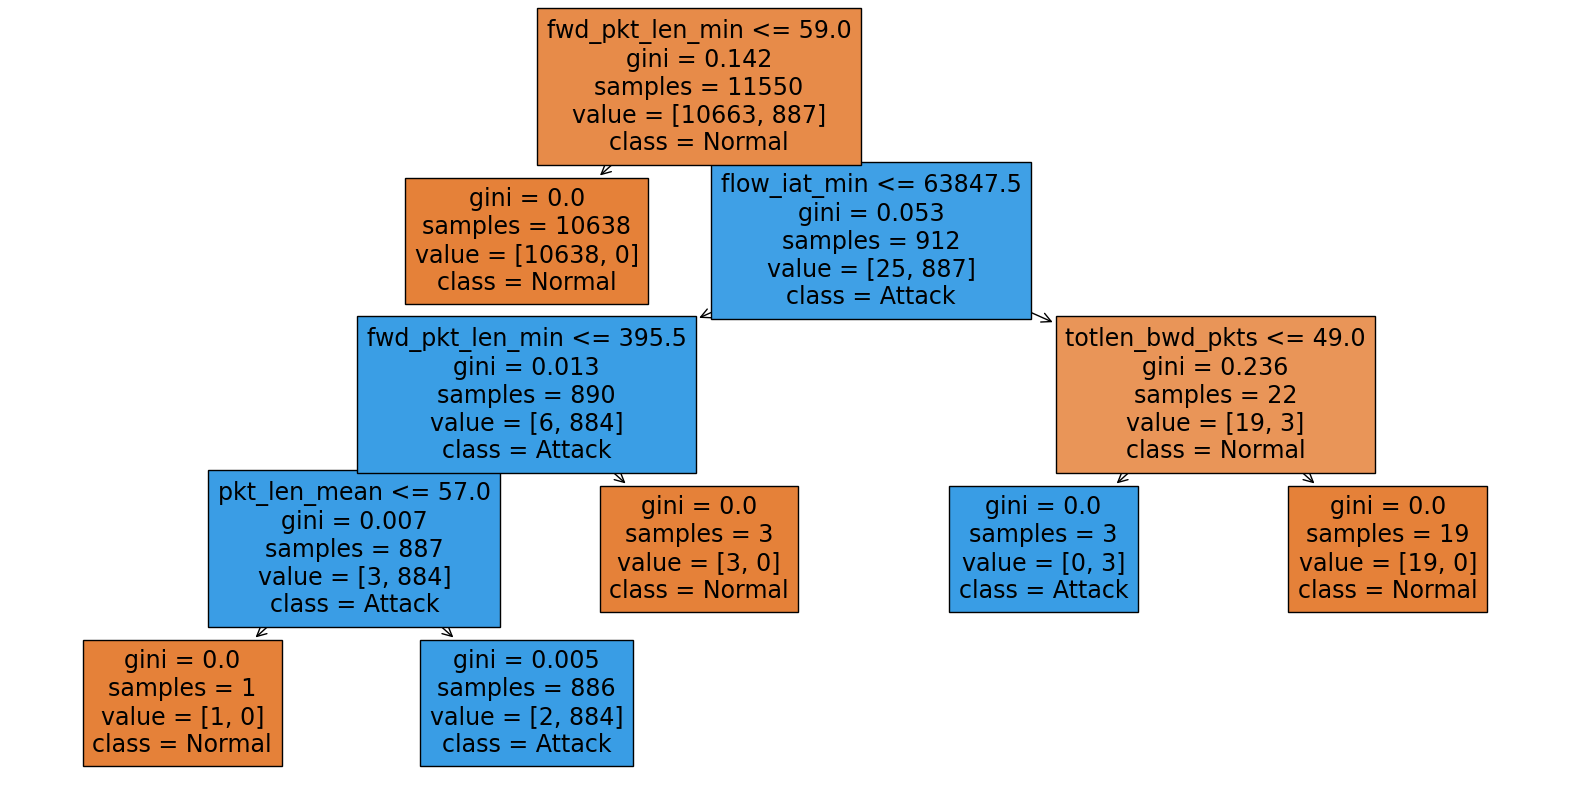

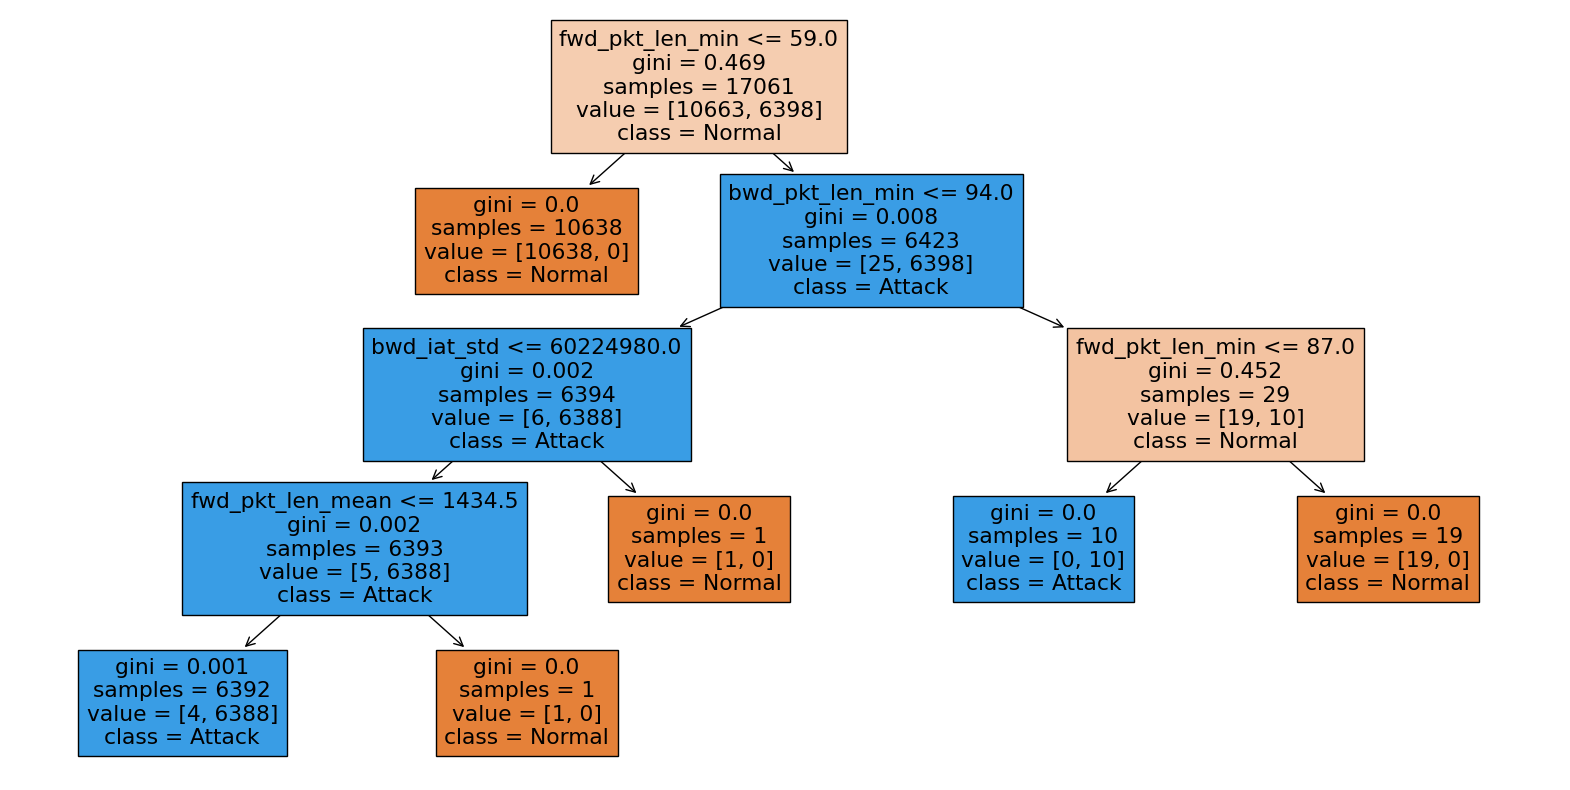

In [4]:
# preparing training dataset 
# normal20 + malicious exact scrnario
# one model for each scenario

import os
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import joblib

def load_and_train(folder_path, normal_data_path, models_save_path):

    normal_data = pd.read_csv(normal_data_path)
    normal_data['label'] = 0  # Oznaczenie ruchu normalnego
    
    # Przeglądanie folderu w poszukiwaniu zbiorów danych złośliwego ruchu
    for filename in os.listdir(folder_path):
        if 'botnet' in filename and filename.endswith('_processed.csv'):
            # Wczytanie i etykietowanie zbioru danych złośliwego
            malicious_data = pd.read_csv(os.path.join(folder_path, filename))
            malicious_data['label'] = 1  # Oznaczenie ruchu złośliwego
            
            # Łączenie zbiorów danych
            combined_data = pd.concat([normal_data, malicious_data], ignore_index=True)
            
            combined_data.drop(['fin_flag_cnt', 'syn_flag_cnt', 'rst_flag_cnt', 'ack_flag_cnt'], axis=1, inplace=True) # for now ommit flags
            
            # Trenowanie modelu Decision Tree
            X = combined_data.drop('label', axis=1)
            y = combined_data['label']

            clf = DecisionTreeClassifier(random_state=42, max_depth=4)  # Mały model
            clf.fit(X, y)
            
            # Zapisywanie wytrenowanego modelu
            model_name = filename.replace('_processed.csv', '_model.pkl')
            joblib.dump(clf, os.path.join(models_save_path, model_name))
            
            # Wyświetlanie struktury modelu
            plt.figure(figsize=(20,10))
            plot_tree(clf, filled=True, feature_names=list(X.columns), class_names=['Normal', 'Attack'])
            plt.show()


processed = '../data/processed'
normal = '../data/processed/CTU13_Normal_Traffic_20.csv'
save = '../models/fitness'
# Przykładowe wywołanie funkcji
load_and_train(processed, normal, save)


In [5]:
X.head()

NameError: name 'X' is not defined

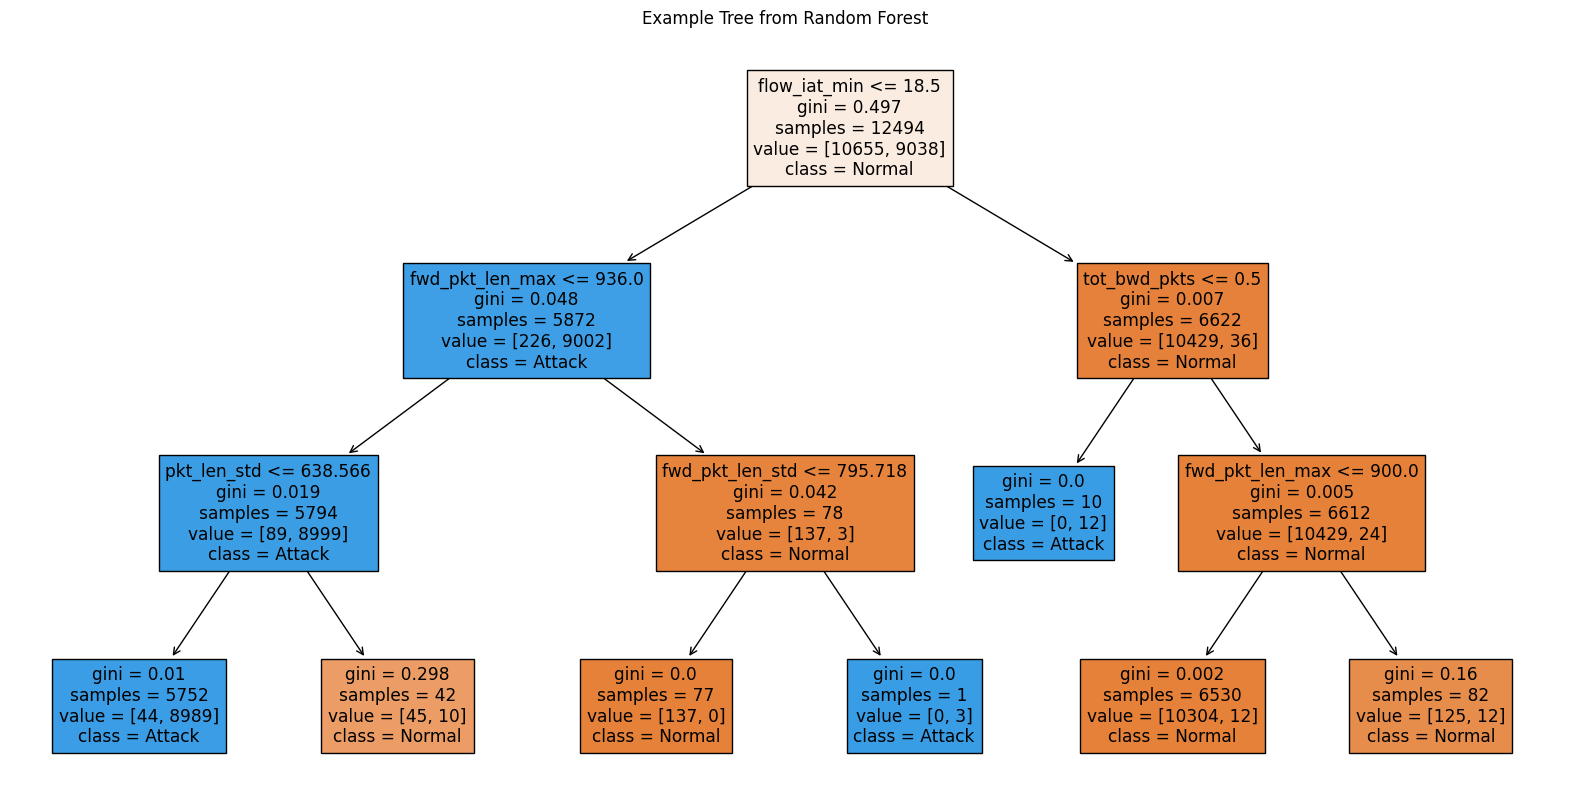

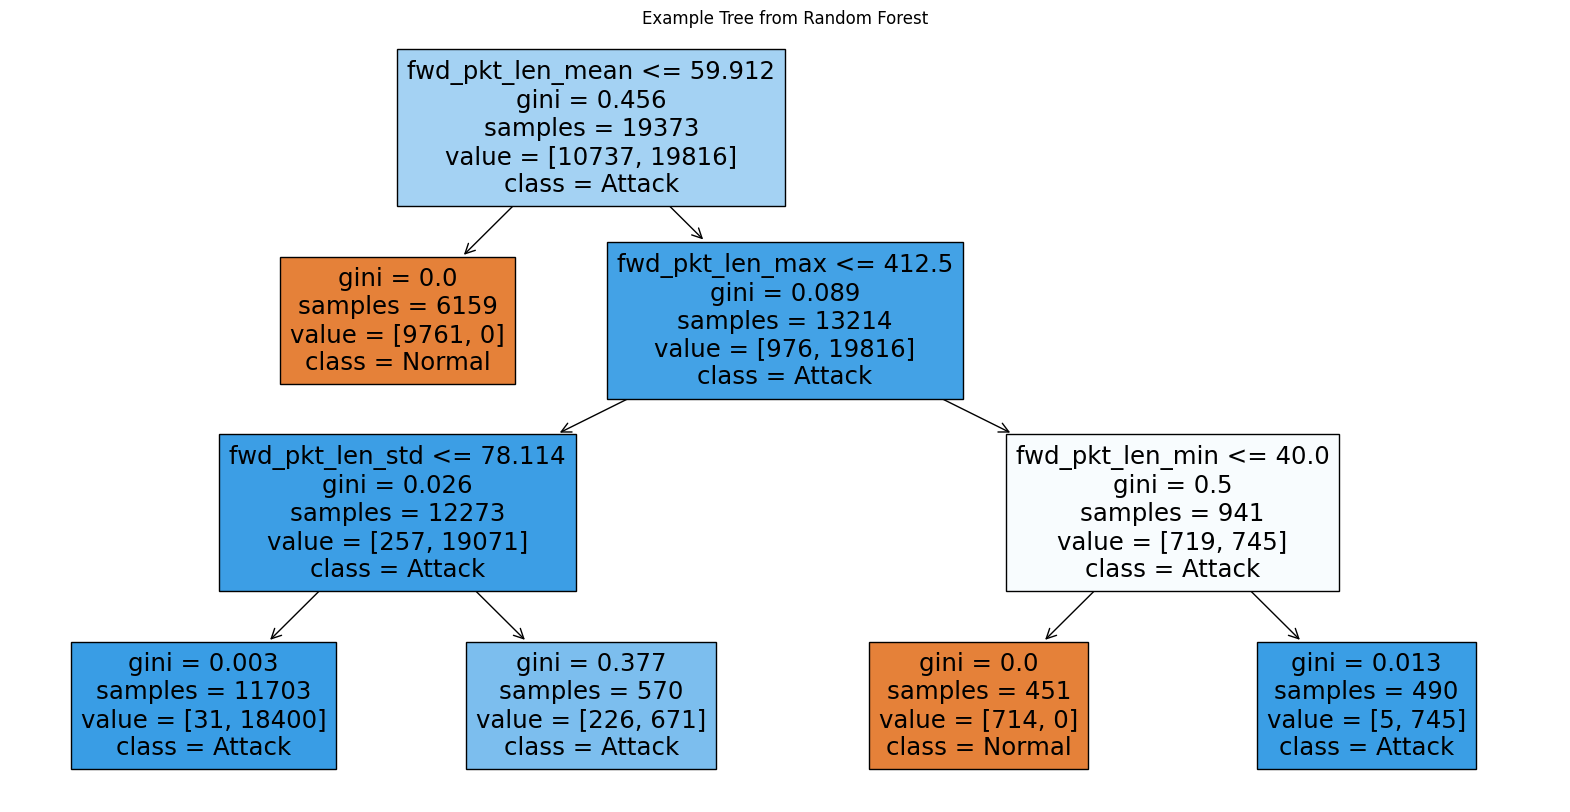

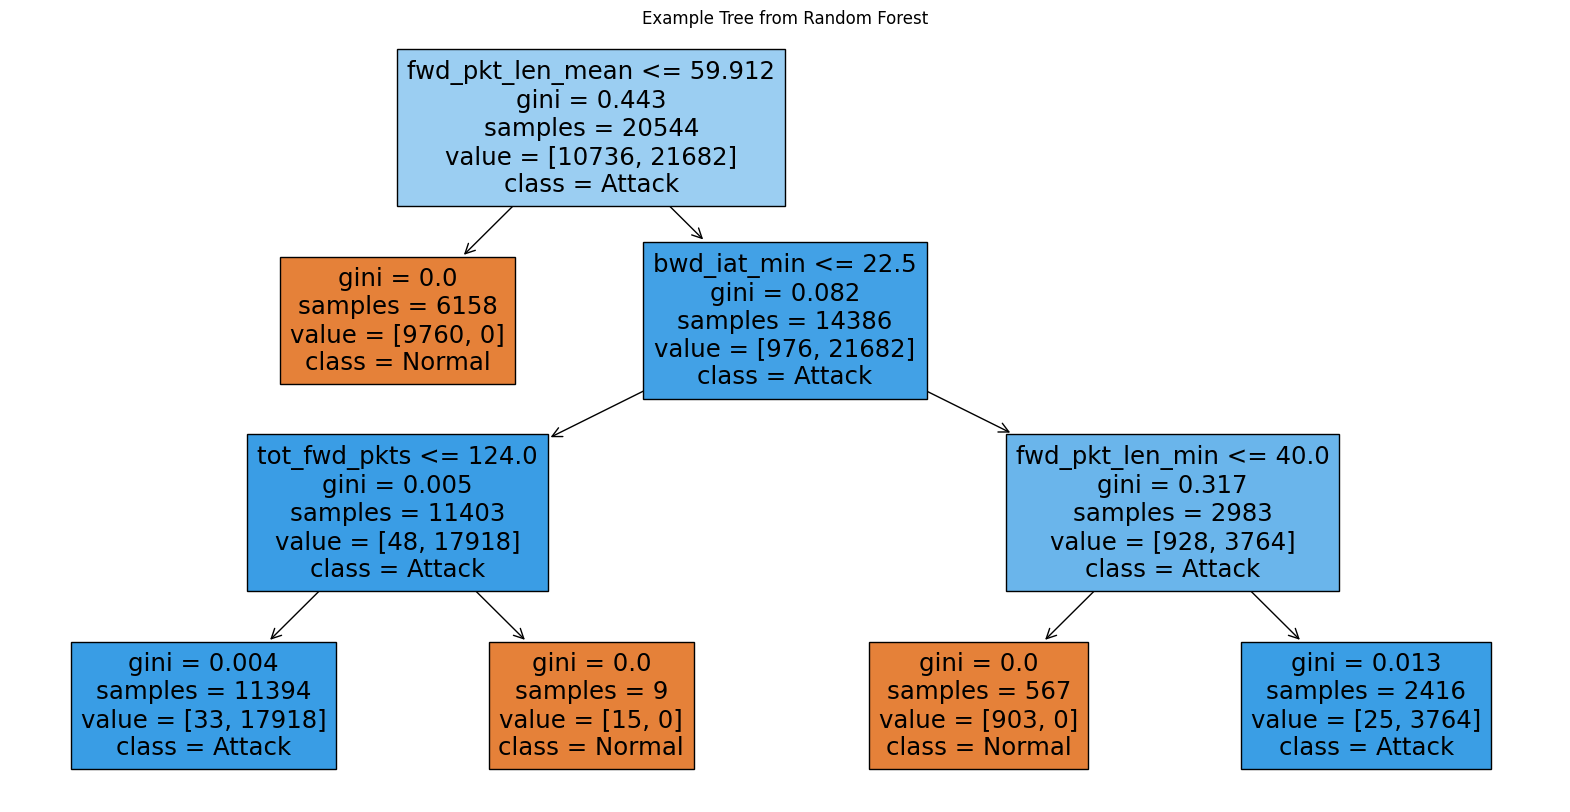

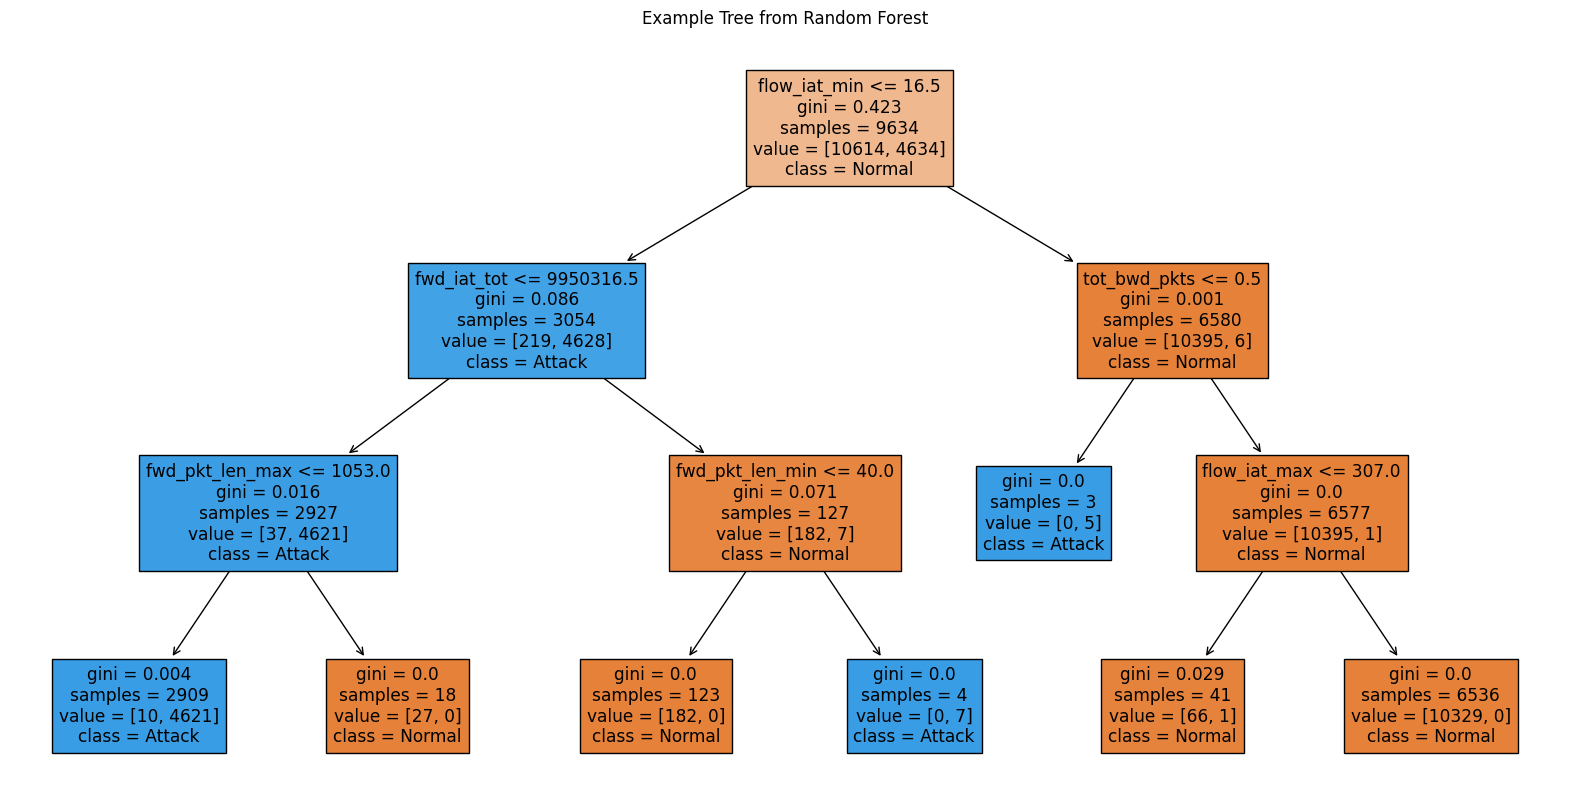

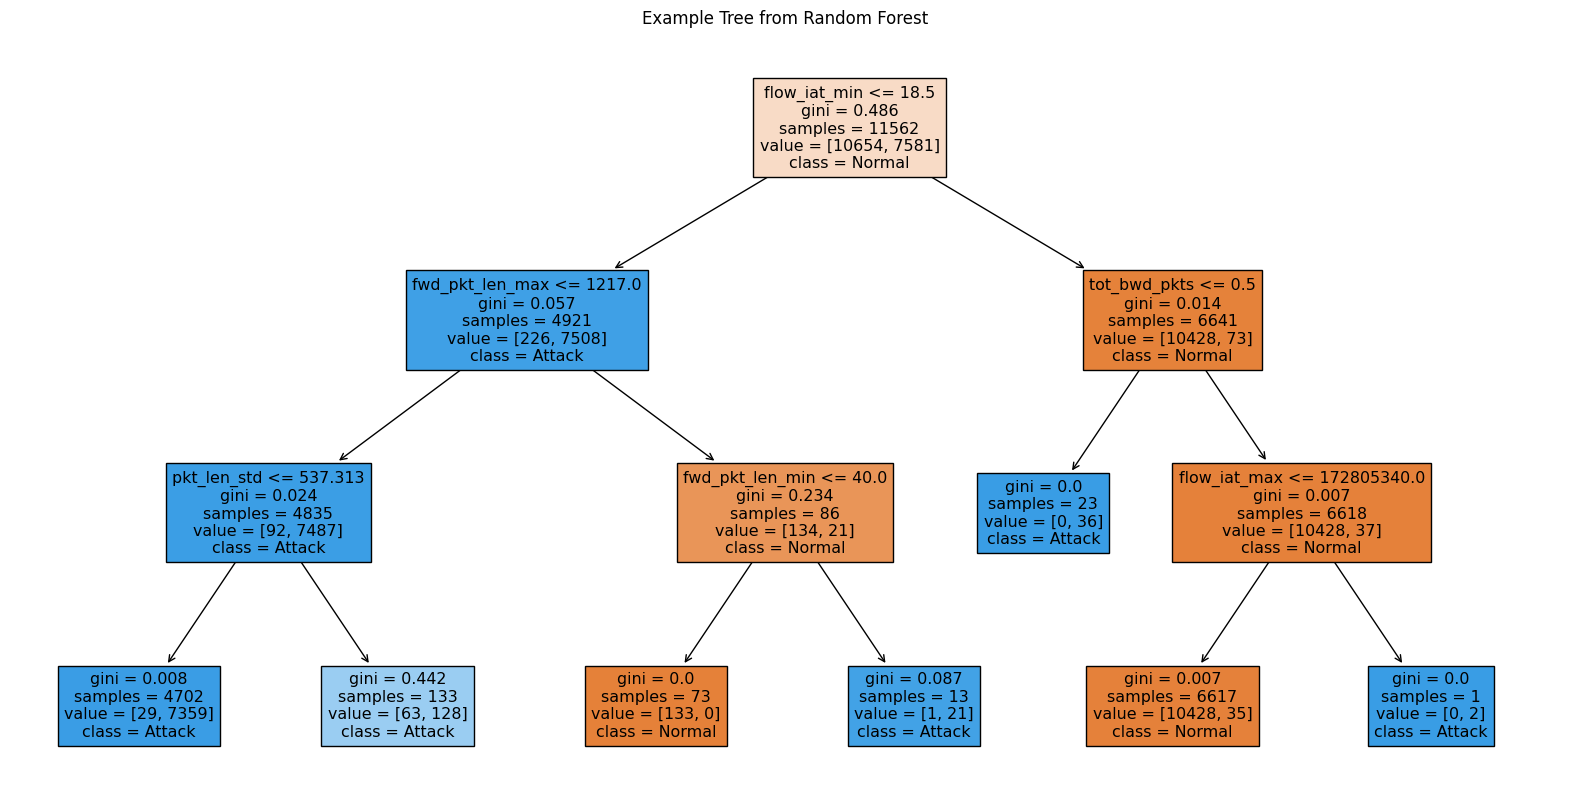

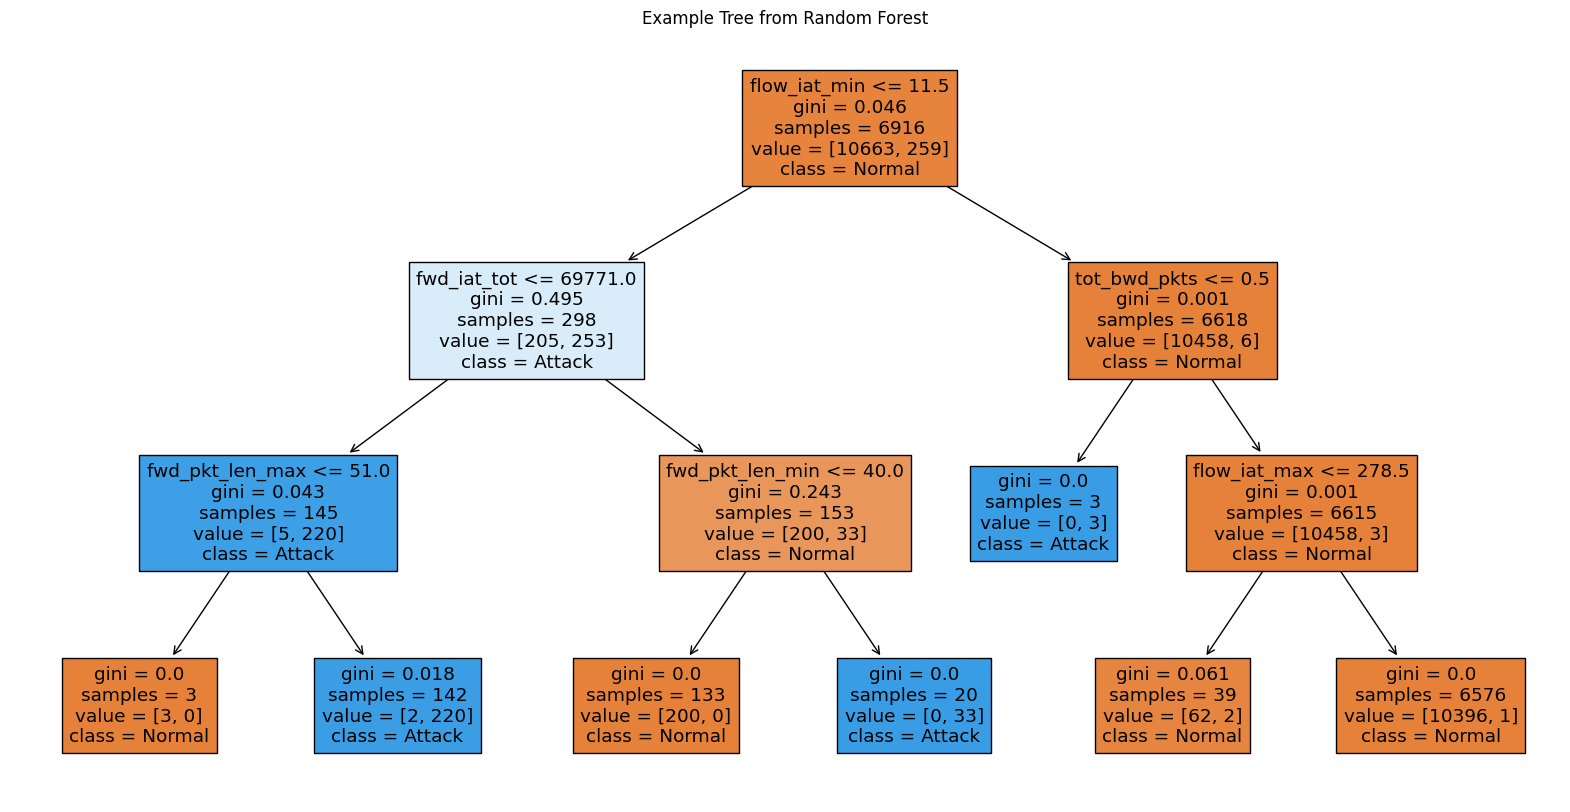

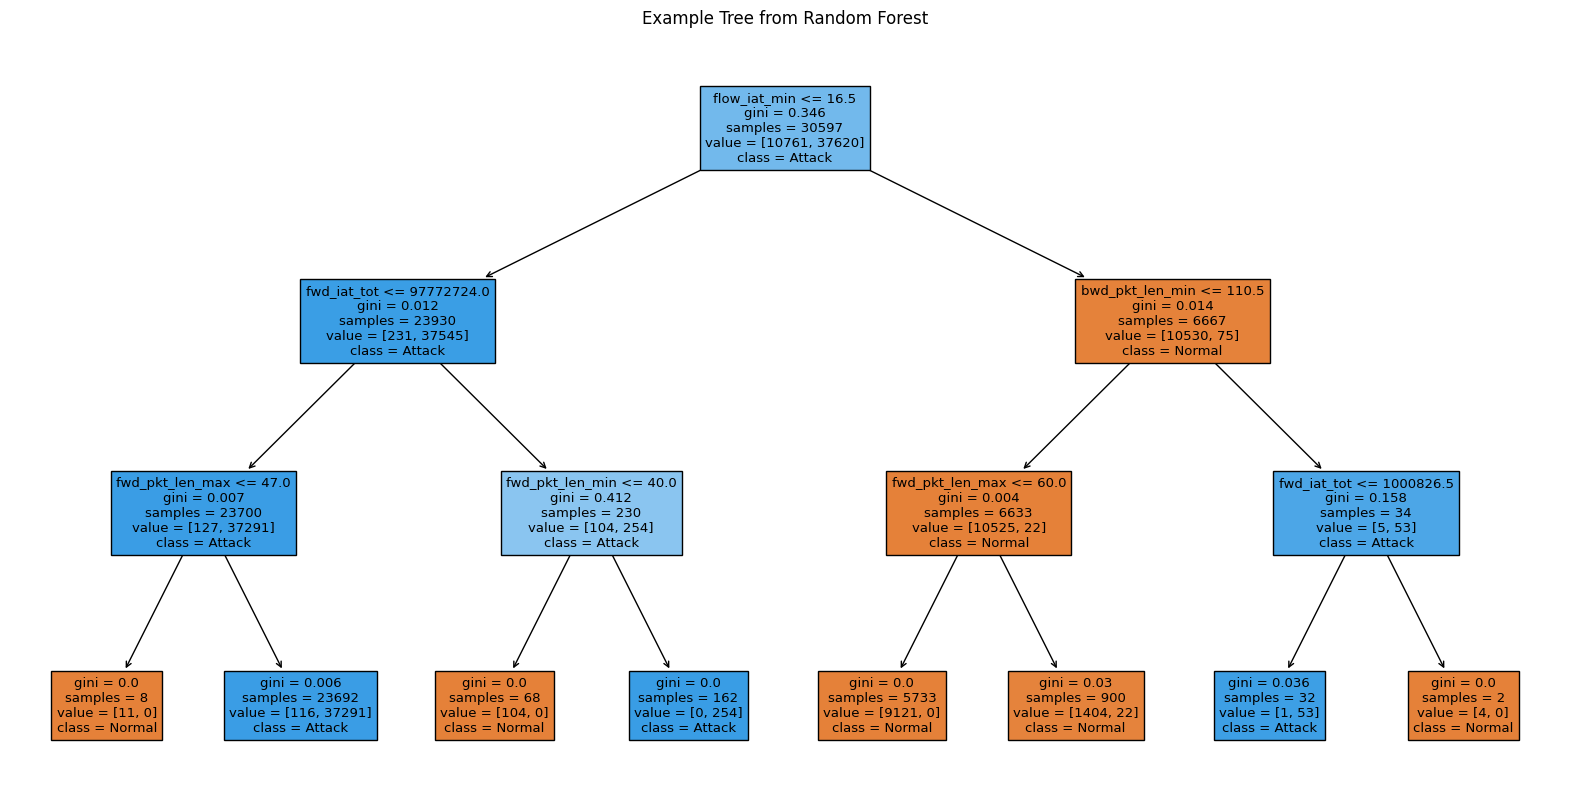

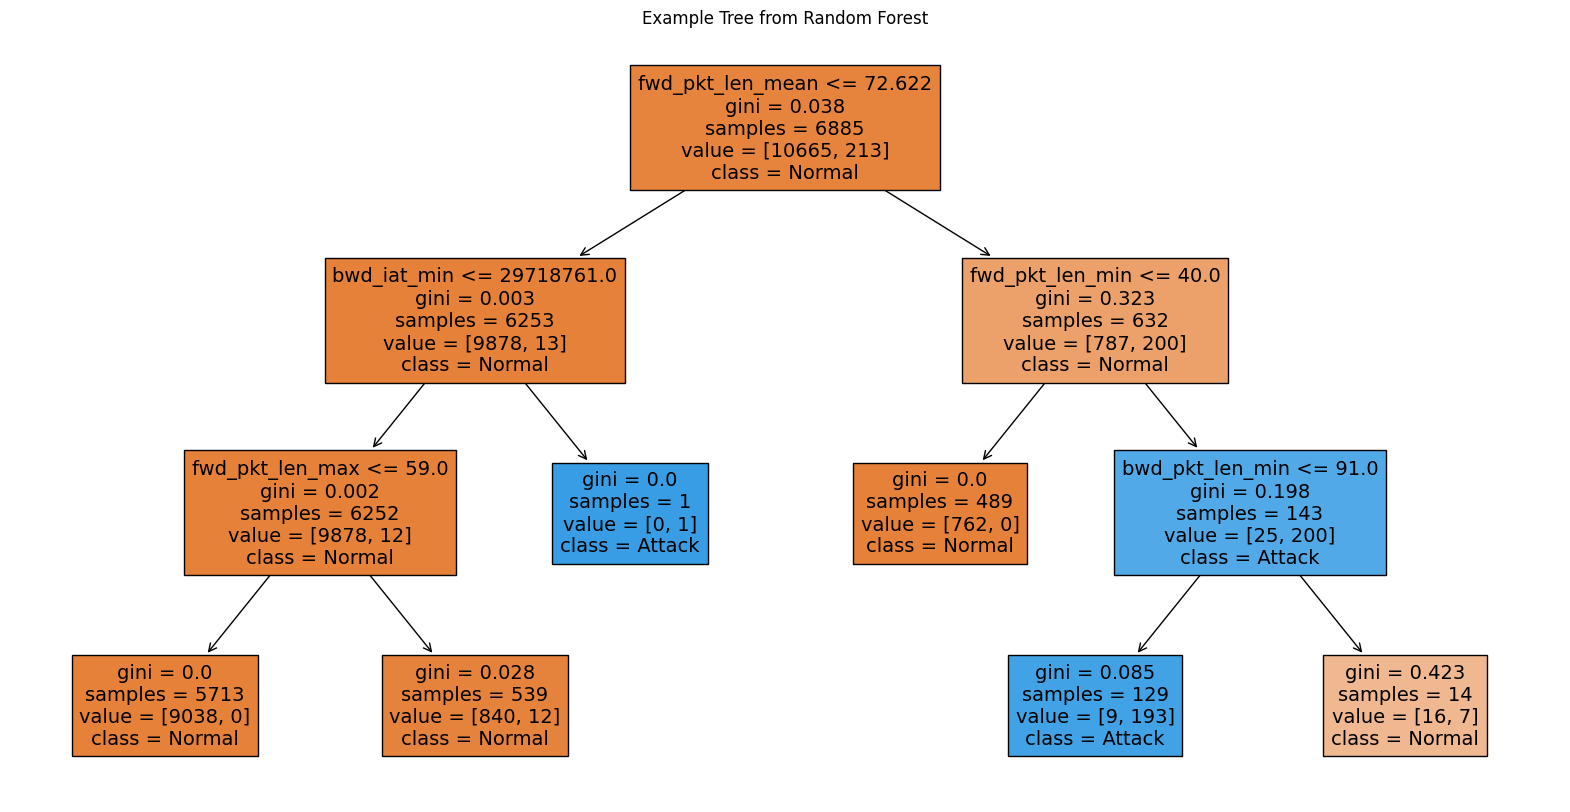

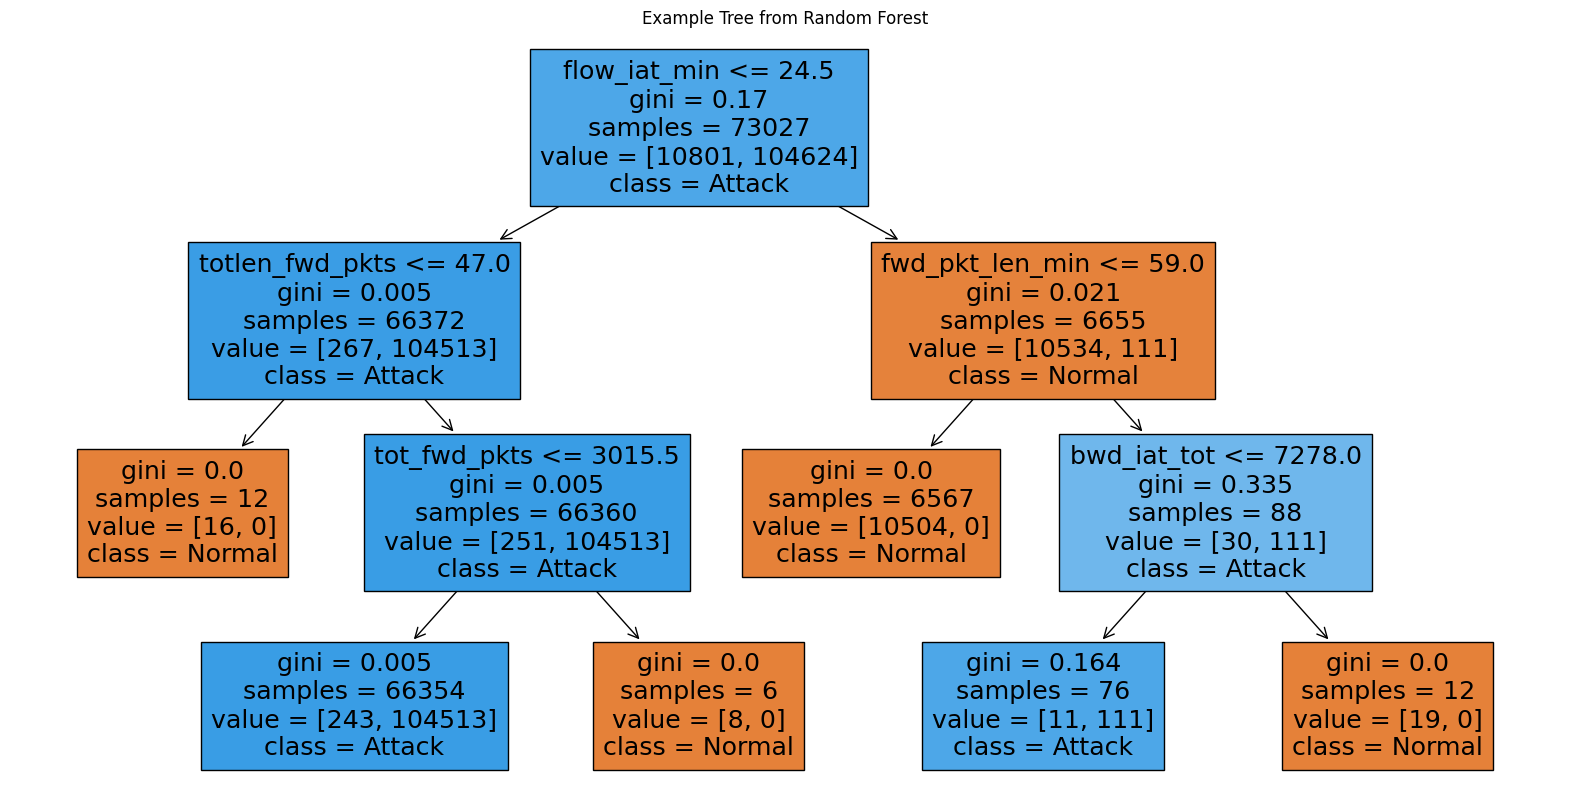

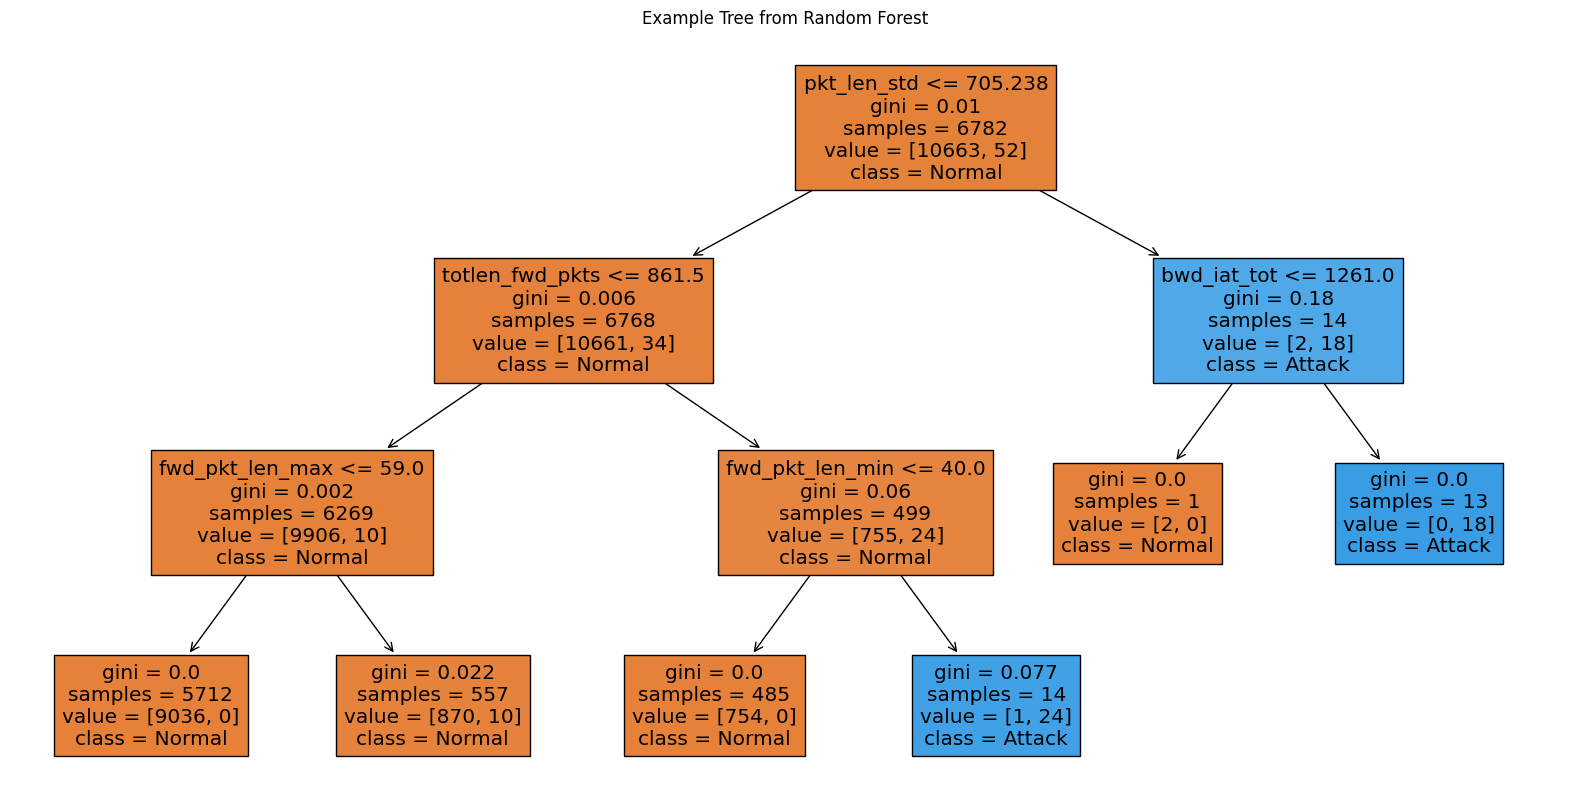

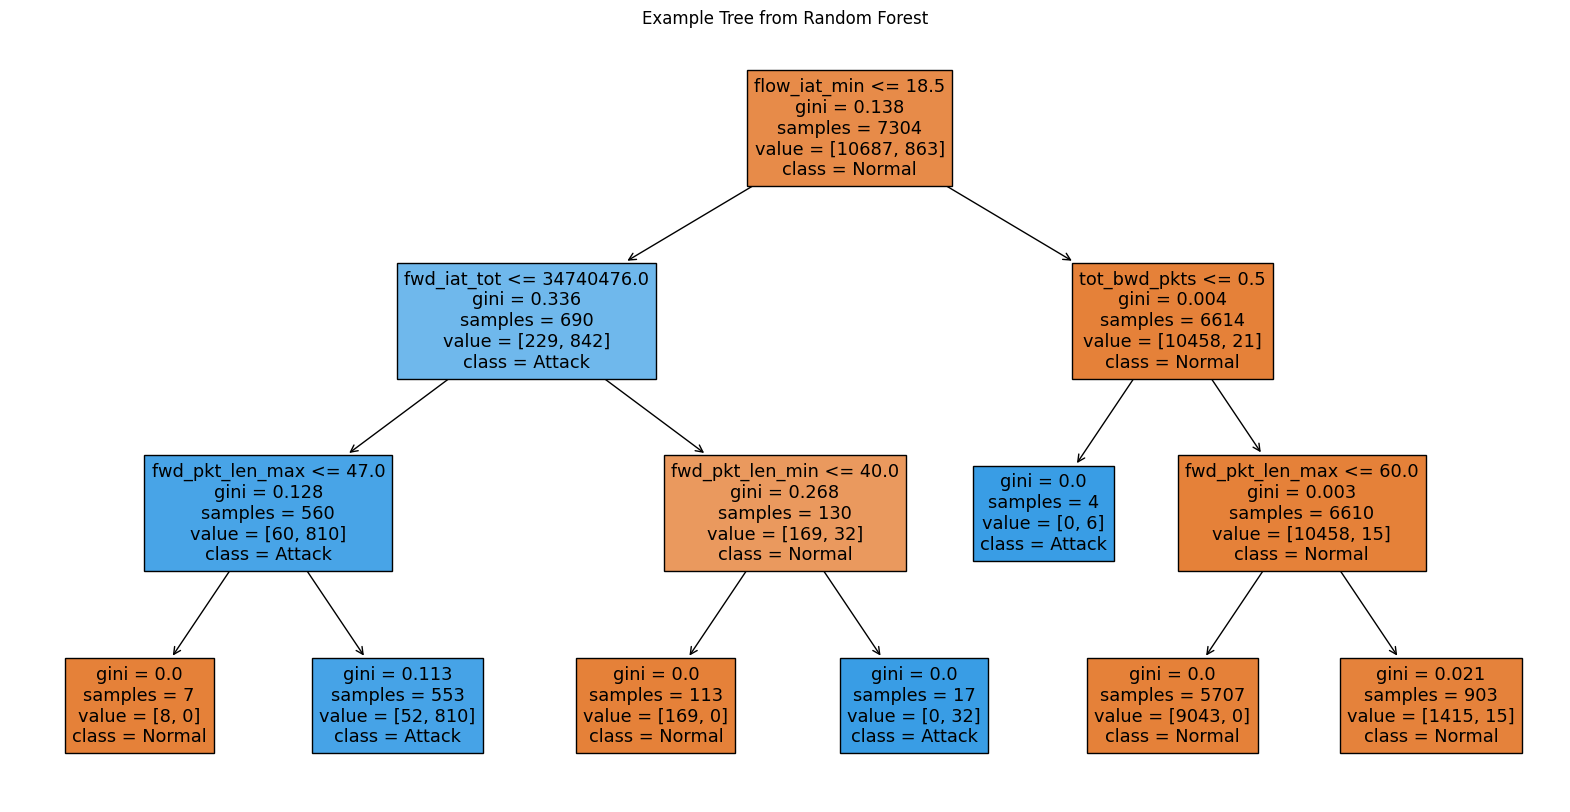

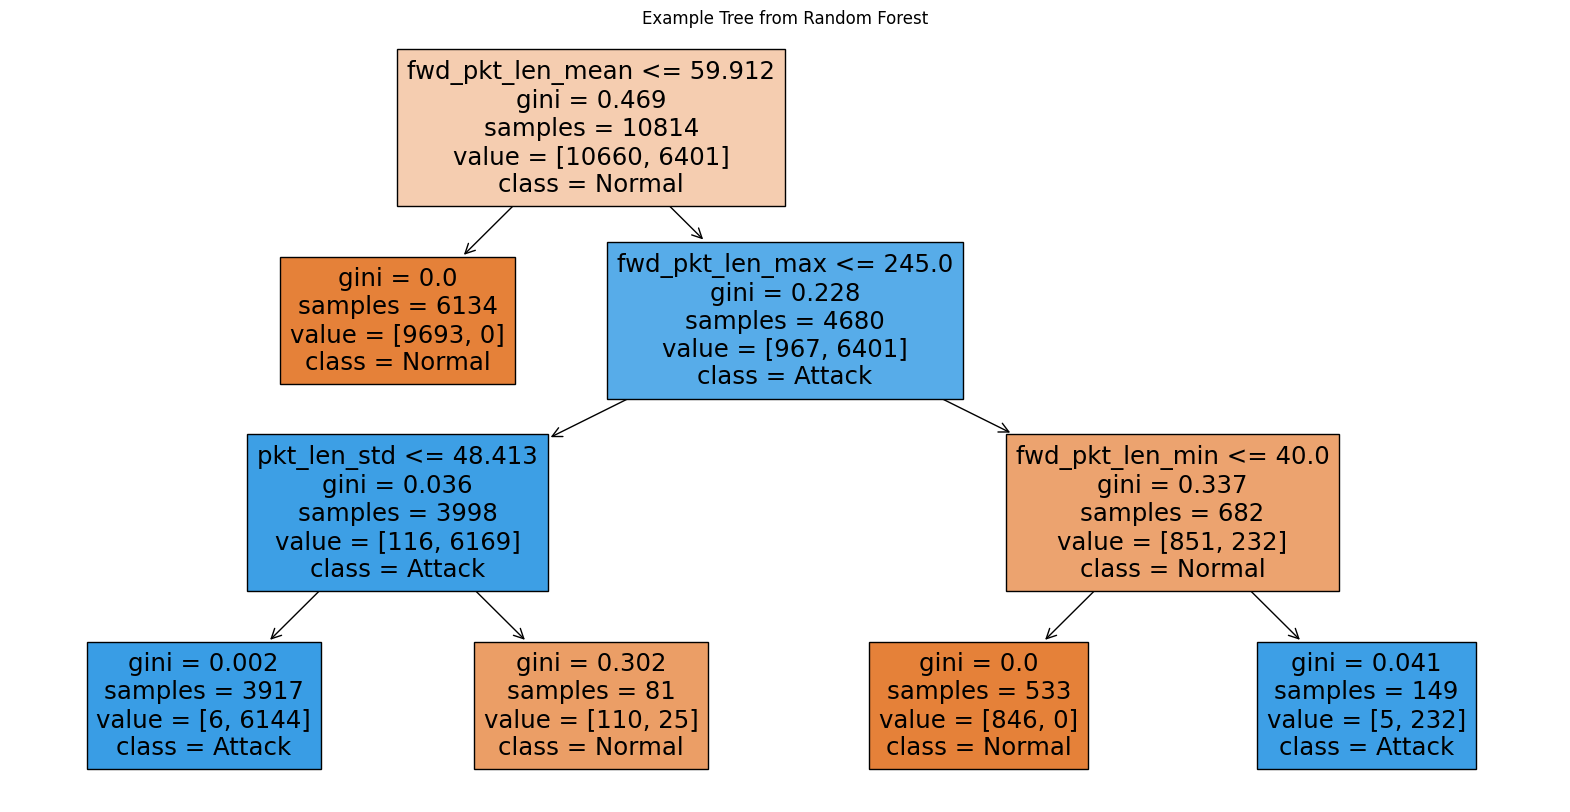

In [ ]:
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import joblib

def load_and_train(folder_path, normal_data_path, models_save_path):
    # Wczytanie zbioru treningowego ruchu normalnego
    normal_data = pd.read_csv(normal_data_path)
    normal_data['label'] = 0  # Oznaczenie ruchu normalnego
    
    # Przeglądanie folderu w poszukiwaniu zbiorów danych złośliwego ruchu
    for filename in os.listdir(folder_path):
        if 'botnet' in filename and filename.endswith('_processed.csv'):
            # Wczytanie i etykietowanie zbioru danych złośliwego
            malicious_data = pd.read_csv(os.path.join(folder_path, filename))
            malicious_data['label'] = 1  # Oznaczenie ruchu złośliwego
            
            # Łączenie zbiorów danych
            combined_data = pd.concat([normal_data, malicious_data], ignore_index=True)
            
            combined_data.drop(['fin_flag_cnt', 'syn_flag_cnt', 'rst_flag_cnt', 'ack_flag_cnt'], axis=1, inplace=True) # for now ommit flag
            
            # Trenowanie modelu RandomForestClassifier
            X = combined_data.drop('label', axis=1)
            y = combined_data['label']
            
            
            clf = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=3)
            clf.fit(X, y)
            
            # Zapisywanie wytrenowanego modelu
            model_name = filename.replace('_processed.csv', '_RF_model.pkl')
            joblib.dump(clf, os.path.join(models_save_path, model_name))
            
            # Wybór i wyświetlenie przykładowego drzewa z lasu
            chosen_tree = clf.estimators_[0]  # Wybieramy pierwsze drzewo jako przykład
            plt.figure(figsize=(20, 10))
            plot_tree(chosen_tree, filled=True, feature_names=list(X.columns), class_names=['Normal', 'Attack'], max_depth=3)
            plt.title("Example Tree from Random Forest")
            plt.show()

processed = '../data/processed'
normal = '../data/processed/CTU13_Normal_Traffic_20.csv'
save = '../models/fitness'
# Przykładowe wywołanie funkcji
load_and_train(processed, normal, save)


In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score
import joblib

import pandas as pd
import joblib
import numpy as np

def test_model(model_path, test_data_path):
    # Wczytanie modelu
    clf = joblib.load(model_path)
    
    # Wczytanie danych testowych
    test_data = pd.read_csv(test_data_path)
    test_data.drop(['fin_flag_cnt', 'syn_flag_cnt', 'rst_flag_cnt', 'ack_flag_cnt'], axis=1, inplace=True)
    X_test = test_data
    
    # Przeprowadzenie predykcji prawdopodobieństwa
    probabilities = clf.predict_proba(X_test)
    
    # Wybór prawdopodobieństw dla klasy złośliwej (zakładamy, że jest to klasa 1)
    malicious_probabilities = probabilities[:, 1]
    
    # Obliczenie średniego prawdopodobieństwa dla klasy złośliwej
    average_malicious_probability = np.mean(malicious_probabilities)
    print(f"Avg mal prob: {average_malicious_probability*100:.2f}%")
    
    return average_malicious_probability



In [ ]:
def cross_test_models(models_folder, data_folder):
    # Wczytanie listy modeli
    model_files = [f for f in os.listdir(models_folder) if f.endswith('_RF_model.pkl')]
    
    # Znalezienie wszystkich plików z danymi złośliwymi do testowania
    data_files = [f for f in os.listdir(data_folder) if 'botnet' in f and f.endswith('_processed.csv')]
    
    prob = 0

    for model_file in model_files:
        probabilities = []  # Lista na średnie prawdopodobieństwa dla poszczególnych testów
        print(f"\nTesting model: {model_file}")
        model_path = os.path.join(models_folder, model_file)
        
        for data_file in data_files:
            test_data_path = os.path.join(data_folder, data_file)
            avg_prob = test_model(os.path.join(models_folder, model_file), test_data_path)
            probabilities.append(avg_prob)
        
        # Obliczenie średniego prawdopodobieństwa złośliwości dla modelu
        if probabilities:
            average_probability = sum(probabilities) / len(probabilities)
            print(f"Average Malicious Probability for {model_file}: {average_probability*100:.2f}%")
            prob += average_probability

    print (prob/len(model_files))


In [ ]:
cross_test_models(save, processed)


Testing model: botnet-capture-20110816-qvod_RF_model.pkl
Avg mal prob: 99.83%
Avg mal prob: 91.37%
Avg mal prob: 71.22%
Avg mal prob: 99.46%
Avg mal prob: 94.06%
Avg mal prob: 98.75%
Avg mal prob: 98.47%
Avg mal prob: 81.27%
Avg mal prob: 97.74%
Avg mal prob: 95.98%
Avg mal prob: 92.43%
Avg mal prob: 84.13%
Average Malicious Probability for botnet-capture-20110816-qvod_RF_model.pkl: 92.06%

Testing model: botnet-capture-20110817-bot_RF_model.pkl
Avg mal prob: 99.81%
Avg mal prob: 97.56%
Avg mal prob: 87.71%
Avg mal prob: 99.96%
Avg mal prob: 96.60%
Avg mal prob: 99.13%
Avg mal prob: 99.94%
Avg mal prob: 90.18%
Avg mal prob: 99.94%
Avg mal prob: 99.53%
Avg mal prob: 99.20%
Avg mal prob: 89.02%
Average Malicious Probability for botnet-capture-20110817-bot_RF_model.pkl: 96.55%

Testing model: botnet-capture-20110816-donbot_RF_model.pkl
Avg mal prob: 89.71%
Avg mal prob: 83.23%
Avg mal prob: 68.43%
Avg mal prob: 99.94%
Avg mal prob: 77.66%
Avg mal prob: 96.84%
Avg mal prob: 73.88%
Avg mal

In [ ]:
def normal_test_models(models_folder, data_folder):
    # Wczytanie listy modeli
    model_files = [f for f in os.listdir(models_folder) if f.endswith('_RF_model.pkl')]
    
    # Znalezienie wszystkich plików z danymi złośliwymi do testowania
    data_files = [f for f in os.listdir(data_folder) if 'Normal' in f and f.endswith('_80.csv')]
    
    prob = 0

    for model_file in model_files:
        probabilities = []  # Lista na średnie prawdopodobieństwa dla poszczególnych testów
        print(f"\nTesting model: {model_file}")
        model_path = os.path.join(models_folder, model_file)
        
        for data_file in data_files:
            test_data_path = os.path.join(data_folder, data_file)
            avg_prob = test_model(os.path.join(models_folder, model_file), test_data_path)
            probabilities.append(avg_prob)
        
        # Obliczenie średniego prawdopodobieństwa złośliwości dla modelu
        if probabilities:
            average_probability = sum(probabilities) / len(probabilities)
            print(f"Average Malicious Probability for {model_file}: {average_probability*100:.2f}%")
            prob += average_probability

    print (prob/len(model_files))


In [ ]:
normal_test_models(save, processed)


Testing model: botnet-capture-20110816-qvod_RF_model.pkl
Avg mal prob: 0.19%
Average Malicious Probability for botnet-capture-20110816-qvod_RF_model.pkl: 0.19%

Testing model: botnet-capture-20110817-bot_RF_model.pkl
Avg mal prob: 0.64%
Average Malicious Probability for botnet-capture-20110817-bot_RF_model.pkl: 0.64%

Testing model: botnet-capture-20110816-donbot_RF_model.pkl
Avg mal prob: 0.06%
Average Malicious Probability for botnet-capture-20110816-donbot_RF_model.pkl: 0.06%

Testing model: botnet-capture-20110819-bot_RF_model.pkl
Avg mal prob: 0.23%
Average Malicious Probability for botnet-capture-20110819-bot_RF_model.pkl: 0.23%

Testing model: botnet-capture-20110816-sogou_RF_model.pkl
Avg mal prob: 0.07%
Average Malicious Probability for botnet-capture-20110816-sogou_RF_model.pkl: 0.07%

Testing model: botnet-capture-20110810-neris_RF_model.pkl
Avg mal prob: 0.53%
Average Malicious Probability for botnet-capture-20110810-neris_RF_model.pkl: 0.53%

Testing model: botnet-capture

In [ ]:
# FITNESS TRUNCATED PACKETS:

# 1) create truncated
# 2) calculate runcated params
# 3) test truncated

In [ ]:
truncated_packets

[TruncatedPacket(packet_id=1, timestamp=1313482194.088306, size=62, pseudo_hash='-3919485749998065278', flow_id=1, direction='1', src_ip=147.32.84.165, fragmented=0, tcp=1, udp=0, fin=0, syn=1, rst=0, ack=0, psh=0, urg=0),
 TruncatedPacket(packet_id=2, timestamp=1313482194.088315, size=62, pseudo_hash='-3919485749998065278', flow_id=1, direction='1', src_ip=147.32.84.165, fragmented=0, tcp=1, udp=0, fin=0, syn=1, rst=0, ack=0, psh=0, urg=0),
 TruncatedPacket(packet_id=3, timestamp=1313482194.151276, size=62, pseudo_hash='-3919485749998065278', flow_id=1, direction='2', src_ip=91.212.135.158, fragmented=0, tcp=1, udp=0, fin=0, syn=1, rst=0, ack=1, psh=0, urg=0),
 TruncatedPacket(packet_id=4, timestamp=1313482194.151598, size=60, pseudo_hash='-3919485749998065278', flow_id=1, direction='1', src_ip=147.32.84.165, fragmented=0, tcp=1, udp=0, fin=0, syn=0, rst=0, ack=1, psh=0, urg=0),
 TruncatedPacket(packet_id=5, timestamp=1313482194.151610, size=60, pseudo_hash='-3919485749998065278', flo

In [ ]:
# sizing




In [ ]:
# timing


In [ ]:
flow_id = 1
sizing_stats = prepare_size_stats(truncated_packets, flow_id)
timing_stats = prepare_timing_stats(truncated_packets, flow_id)

In [ ]:
sizing_stats

{'tot_fwd_pkts': 1090,
 'tot_bwd_pkts': 635,
 'totlen_fwd_pkts': 65646,
 'totlen_bwd_pkts': 1209780,
 'fwd_pkt_len_max': 174,
 'fwd_pkt_len_min': 60,
 'fwd_pkt_len_mean': 60.225688073394494,
 'fwd_pkt_len_std': 4.885710369123273,
 'bwd_pkt_len_max': 4434,
 'bwd_pkt_len_min': 60,
 'bwd_pkt_len_mean': 1905.1653543307086,
 'bwd_pkt_len_std': 701.5260190007999,
 'pkt_len_mean': 739.3773913043478,
 'pkt_len_std': 986.3701563824255}

In [ ]:
timing_stats

{'flow_iat_mean': 1099.9669373549882,
 'flow_iat_max': 163625.0,
 'flow_iat_min': 0.0,
 'flow_iat_std': 8067.8267672643215,
 'fwd_iat_tot': 0,
 'fwd_iat_max': 163966.0,
 'fwd_iat_min': 0.0,
 'fwd_iat_mean': 1683.2203856749313,
 'fwd_iat_std': 9974.730315269562,
 'bwd_iat_tot': 0,
 'bwd_iat_max': 164537.0,
 'bwd_iat_min': 5.0,
 'bwd_iat_mean': 2891.7555205047315,
 'bwd_iat_std': 13004.028339654073}

In [10]:
import pandas as pd
import joblib
import numpy as np

def predict_single_flow(model_name, sizing_stats, timing_stats):
    # Łączenie statystyk w jeden słownik
    flow_stats = {**sizing_stats, **timing_stats}
    
    # Konwersja słownika do DataFrame
    flow_df = pd.DataFrame([flow_stats])
    
    # Wczytanie modelu
    # Zmienna `models_folder` powinna być zdefiniowana wcześniej w kodzie lub tutaj bezpośrednio
    models_folder = save # TODO
    clf = joblib.load(f"{models_folder}/{model_name}_RF_model.pkl")
    
    # Przeprowadzenie predykcji prawdopodobieństwa
    probabilities = clf.predict_proba(flow_df)
    
    # Wybór prawdopodobieństwa dla klasy złośliwej (zakładając, że jest to klasa 1)
    malicious_probability = probabilities[0][1]
    
    print(f"Malicious score (probability) for the flow: {malicious_probability*100:.2f}%")
    
    return malicious_probability


model_name = 'botnet-capture-20110815-fast-flux-2'
predict_single_flow(model_name, sizing_stats, timing_stats)


NameError: name 'save' is not defined

In [8]:
flow_id = 1
processed = '../data/processed'
normal = '../data/processed/CTU13_Normal_Traffic_20.csv'
save = '../models/fitness'
sizing_stats = prepare_size_stats(truncated_packets, flow_id)
timing_stats = prepare_timing_stats(truncated_packets, flow_id)
predict_single_flow(model_name, sizing_stats, timing_stats)

NameError: name 'calculate_size_statistics' is not defined